In [ ]:
import zipfile
import pandas as pd
import polars as pl
import geopandas as gpd
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import re
import pycountry
import geodata
from tqdm import tqdm
from zipfile import ZipFile
from geopy.geocoders import Nominatim
import time
import urllib.request
import pycountry
from google.colab import files
import matplotlib.pyplot as plt
import contextily as ctx
import fiona
import tools
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import unicodedata
import pickle
import osmnx as ox
from concurrent.futures import ThreadPoolExecutor, as_completed
from shapely.geometry import Point
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
from itertools import product
from difflib import get_close_matches

In [ ]:
FONTSIZE = 18
params = {
         'axes.labelsize': FONTSIZE,
         'axes.titlesize': FONTSIZE,
         'xtick.labelsize':FONTSIZE,
         'legend.fontsize':FONTSIZE,
         'ytick.labelsize':FONTSIZE}

plt.rcParams.update(params)

image_folder = '/content/Linking-Plastic-to-Dengue-Incidence/plots'
data_folder = '/content/Linking-Plastic-to-Dengue-Incidence/data'
os.makedirs(image_folder, exist_ok=True)
os.makedirs(data_folder, exist_ok=True)

In [ ]:
# Load the file
gadm_subset = gpd.read_file(f"{data_folder}/gadm_subset_gdf.gpkg")

# Reproject to World Mollweide (suitable for global area-preserving calculations)
gdf_projected = gadm_subset.to_crs(epsg=3857)

# Compute centroids in projected space
gdf_projected["centroid"] = gdf_projected.geometry.centroid

# Create GeoDataFrame from centroids and reproject back to EPSG:4326
gdf_projected = gdf_projected.set_geometry("centroid")
gdf_centroids = gdf_projected.to_crs(epsg=4326)

# Extract Point geometry back into original GeoDataFrame
gadm_subset["centroid"] = gdf_centroids.geometry

gadm_subset

adm_0_name  adm_1_name        adm_2_name        GID_2  \
0      afghanistan  badakhshan           baharak    AFG.1.1_1   
1      afghanistan  badakhshan            darwaz    AFG.1.2_1   
2      afghanistan  badakhshan          fayzabad    AFG.1.3_1   
3      afghanistan  badakhshan         ishkashim    AFG.1.4_1   
4      afghanistan  badakhshan              jurm    AFG.1.5_1   
...            ...         ...               ...          ...   
47212     zimbabwe    midlands          redcliff  ZWE.10.10_2   
47213     zimbabwe    midlands          shurugwi  ZWE.10.11_2   
47214     zimbabwe    midlands     shurugwi town  ZWE.10.12_2   
47215     zimbabwe    midlands        zvishavane  ZWE.10.13_2   
47216     zimbabwe    midlands  zvishavane urban  ZWE.10.14_2   

                                                geometry  \
0      MULTIPOLYGON (((71.41149 36.55717, 71.40954 36...   
1      MULTIPOLYGON (((71.2762 38.00465, 71.27578 38....   
2      MULTIPOLYGON (((70.78272 37.27678, 70.78635 37...   
3      MULTIPOLYGON (((71.41149 36.55717, 71.40091 36...   
4      MULTIPOLYGON (((70.71236 37.07621, 70.73582 37...   
...                                                  ...   
47212  MULTIPOLYGON (((29.69907 -19.00888, 29.71847 -...   
47213  MULTIPOLYGON (((29.8756 -20.0057, 29.87369 -20...   
47214  MULTIPOLYGON (((30.05583 -19.69895, 30.05583 -...   
47215  MULTIPOLYGON (((30.37508 -20.44078, 30.37532 -...   
47216  MULTIPOLYGON (((30.0686 -20.29432, 30.06866 -2...   

                         centroid  
0        POINT (71.10439 37.0221)  
1       POINT (70.93919 38.21125)  
2       POINT (70.47054 37.11547)  
3       POINT (71.42752 36.80869)  
4       POINT (70.82746 36.58068)  
...                           ...  
47212  POINT (29.76587 -19.02287)  
47213  POINT (30.15292 -19.75044)  
47214  POINT (29.99794 -19.69372)  
47215   POINT (30.07875 -20.2774)  
47216  POINT (30.05384 -20.31986)  

[47217 rows x 6 columns]

In [ ]:
gadm_subset.adm_0_name.unique().shape

(171,)

### Load and read the data - Use Statistic = Median

These columns represent variables from the **SPOT model outputs**, likely in datasets like `SD_03`, `SD_04`, or `SD_05`. Here’s a breakdown of their meanings, grouped by category:

---

### **1. Geographic & Administrative Identifiers**
- **`Statistic`**: Type of statistical measure (e.g., mean, median, 5th/95th percentile).
- **`Country`**: Country name.
- **`ISO3`**: 3-letter country code (e.g., USA for United States).
- **`Income_cat`**: World Bank income category (e.g., Low-Income, High-Income).
- **`Region`**: Broad geographic region (e.g., Asia, Africa).
- **`Subregion`**: Smaller subdivisions (e.g., Eastern Africa, South America).
- **`Intermediate_region`**: Further regional breakdown (if applicable).
- **`OECD_region`**: Whether the country is in an OECD-defined region (e.g., OECD member).
- **`Municipality`**: Local administrative unit (e.g., city, town).
- **`Unique_ID`**: Unique identifier for the municipality.

---

### **2. Population & Urbanization**
- **`Population_2020`**: Total population in 2020.
- **`Rural_share`**: Percentage of population living in rural areas.
- **`Deg_Urban_Lv1`/`Deg_Urban_Lv2`**: Classification of urbanization level (e.g., urban, peri-urban, rural).

---

### **3. Waste Generation**
- **`wg`**: Total waste generated (tonnes/year).
- **`wg_per_cap`**: Waste generated per capita (kg/person/year).
- **`pwg`**: Plastic waste generated (tonnes/year).
- **`pwg_per_cap`**: Plastic waste generated per capita (kg/person/year).

---

### **4. Waste Collection & Disposal**
- **`col_cov_pct_gen_exc_lit`**: Percentage of waste collected (excluding litter).
- **`col_del_pct_gen`**: Percentage of waste collected and delivered to disposal/recycling.
- **`litter_em_pct_gen`**: Percentage of generated waste emitted as litter.
- **`uncol_em_pct_gen`**: Percentage of uncollected waste emitted to the environment.
- **`collection_em_pct_gen`**: Waste emitted during collection (e.g., leakage from trucks).
- **`cont_disp_pct_gen`**: Percentage of waste disposed in **contained systems** (e.g., landfills).
- **`uncont_disp_pct_gen`**: Percentage of waste disposed in **uncontained systems** (e.g., open dumps).
- **`compost_pct_gen`**: Percentage of waste composted.
- **`incin_pct_gen`**: Percentage of waste incinerated.
- **`recy_pct_gen`**: Percentage of waste recycled.

---

### **5. Recycling & Disposal Subcategories**
- **`recy_form_pct_recy`**: Percentage of recycling done formally (regulated).
- **`recy_inform_pct_recy`**: Percentage of recycling done informally (unregulated).
- **`cont_disp_pct_disp`**: Percentage of **disposed waste** that is contained.
- **`uncont_disp_pct_disp`**: Percentage of **disposed waste** that is uncontained.
- **`man_cont_pct_gen`**: Percentage of waste managed in contained systems.

---

### **6. Emissions & Pollution**
- **`open_burn_MSW`**: Open burning of municipal solid waste (tonnes/year).
- **`open_burn_MSW_pct_gen`**: Percentage of waste openly burned.
- **`plas_debris_em`**: Plastic debris emitted to the environment (tonnes/year).
- **`plas_burn_em`**: Plastic burned (open burning, incineration) (tonnes/year).
- **`plas_em`**: Total plastic emissions (debris + burned) (tonnes/year).
- **`plas_debris_em_pct_em`**: Percentage of emissions from debris (vs. burning).
- **`plas_burn_em_pct_em`**: Percentage of emissions from burning.
- **`..._per_cap`**: Per capita values (kg/person/year).

---

### **7. Plastic Type & Pathway Breakdown**
- **`rigid_plas_deb_em`**: Emissions from rigid plastics (e.g., bottles).
- **`flex_plas_deb_em`**: Emissions from flexible plastics (e.g., bags).
- **`rigid_plas_ob_em`**: Rigid plastics burned.
- **`flex_plas_ob_em`**: Flexible plastics burned.
- **`..._pct_em`**: Percentage contribution to total emissions.

---

### **8. Emission Pathways**
- **`plas_litter_em`**: Plastic littered directly.
- **`plas_uncol_em`**: Plastic uncollected and emitted.
- **`plas_collection_em`**: Plastic leaked during collection.
- **`plas_disp_em`**: Plastic leaked from disposal sites.
- **`plas_recy_em`**: Plastic leaked during recycling.
- **`..._pct_em`**: Percentage of emissions from each pathway.

---

### **9. Population Affected**
- **`people_no_col`**: Population without waste collection services.
- **`people_no_col_pct_pop`**: Percentage of population without collection.

---

### Key Notes:
- **`pct`**: Abbreviation for *percentage*.
- **`gen`**: Refers to *generated waste*.
- **`disp`**: *Disposal*.
- **`cont`**: *Contained* (e.g., landfills).
- **`uncont`**: *Uncontained* (e.g., open dumps).
- **`plas`**: *Plastic*.
- **`debris`**: Plastic entering the environment as litter or leakage.
- **`ob`**: *Open burning*.

For deeper insights, refer to the **"legend" sheets** in the Excel files (e.g., `SD_02`, `SD_05`), which define variables and units. Let me know if you need help with specific calculations or abbreviations!

In [ ]:
plastic_file[['Statistic', 'Country', 'Income_cat', 'Region', 'Municipality', 'Unique_ID', 'plas_litter_em', 'Population_2020']].tail(40)

Statistic   Country Income_cat  Region Municipality   Unique_ID  \
304172   Lower quartile  Zimbabwe        LIC  Africa  Gokwe North  ZWE.10.2_1   
304173           Median  Zimbabwe        LIC  Africa  Gokwe North  ZWE.10.2_1   
304174   Upper quartile  Zimbabwe        LIC  Africa  Gokwe North  ZWE.10.2_1   
304175  95th percentile  Zimbabwe        LIC  Africa  Gokwe North  ZWE.10.2_1   
304176             Mean  Zimbabwe        LIC  Africa  Gokwe South  ZWE.10.3_1   
304177   5th percentile  Zimbabwe        LIC  Africa  Gokwe South  ZWE.10.3_1   
304178   Lower quartile  Zimbabwe        LIC  Africa  Gokwe South  ZWE.10.3_1   
304179           Median  Zimbabwe        LIC  Africa  Gokwe South  ZWE.10.3_1   
304180   Upper quartile  Zimbabwe        LIC  Africa  Gokwe South  ZWE.10.3_1   
304181  95th percentile  Zimbabwe        LIC  Africa  Gokwe South  ZWE.10.3_1   
304182             Mean  Zimbabwe        LIC  Africa        Gweru  ZWE.10.4_1   
304183   5th percentile  Zimbabwe        LIC  Africa        Gweru  ZWE.10.4_1   
304184   Lower quartile  Zimbabwe        LIC  Africa        Gweru  ZWE.10.4_1   
304185           Median  Zimbabwe        LIC  Africa        Gweru  ZWE.10.4_1   
304186   Upper quartile  Zimbabwe        LIC  Africa        Gweru  ZWE.10.4_1   
304187  95th percentile  Zimbabwe        LIC  Africa        Gweru  ZWE.10.4_1   
304188             Mean  Zimbabwe        LIC  Africa       Kwekwe  ZWE.10.5_1   
304189   5th percentile  Zimbabwe        LIC  Africa       Kwekwe  ZWE.10.5_1   
304190   Lower quartile  Zimbabwe        LIC  Africa       Kwekwe  ZWE.10.5_1   
304191           Median  Zimbabwe        LIC  Africa       Kwekwe  ZWE.10.5_1   
304192   Upper quartile  Zimbabwe        LIC  Africa       Kwekwe  ZWE.10.5_1   
304193  95th percentile  Zimbabwe        LIC  Africa       Kwekwe  ZWE.10.5_1   
304194             Mean  Zimbabwe        LIC  Africa    Mberengwa  ZWE.10.6_1   
304195   5th percentile  Zimbabwe        LIC  Africa    Mberengwa  ZWE.10.6_1   
304196   Lower quartile  Zimbabwe        LIC  Africa    Mberengwa  ZWE.10.6_1   
304197           Median  Zimbabwe        LIC  Africa    Mberengwa  ZWE.10.6_1   
304198   Upper quartile  Zimbabwe        LIC  Africa    Mberengwa  ZWE.10.6_1   
304199  95th percentile  Zimbabwe        LIC  Africa    Mberengwa  ZWE.10.6_1   
304200             Mean  Zimbabwe        LIC  Africa     Shurugwi  ZWE.10.7_1   
304201   5th percentile  Zimbabwe        LIC  Africa     Shurugwi  ZWE.10.7_1   
304202   Lower quartile  Zimbabwe        LIC  Africa     Shurugwi  ZWE.10.7_1   
304203           Median  Zimbabwe        LIC  Africa     Shurugwi  ZWE.10.7_1   
304204   Upper quartile  Zimbabwe        LIC  Africa     Shurugwi  ZWE.10.7_1   
304205  95th percentile  Zimbabwe        LIC  Africa     Shurugwi  ZWE.10.7_1   
304206             Mean  Zimbabwe        LIC  Africa   Zvishavane  ZWE.10.8_1   
304207   5th percentile  Zimbabwe        LIC  Africa   Zvishavane  ZWE.10.8_1   
304208   Lower quartile  Zimbabwe        LIC  Africa   Zvishavane  ZWE.10.8_1   
304209           Median  Zimbabwe        LIC  Africa   Zvishavane  ZWE.10.8_1   
304210   Upper quartile  Zimbabwe        LIC  Africa   Zvishavane  ZWE.10.8_1   
304211  95th percentile  Zimbabwe        LIC  Africa   Zvishavane  ZWE.10.8_1   

        plas_litter_em  Population_2020  
304172       73.559742    300029.160359  
304173      128.810365    300029.160359  
304174      202.955558    300029.160359  
304175      328.085571    300029.160359  
304176      218.711019    411992.807116  
304177       54.369791    411992.807116  
304178      117.734743    411992.807116  
304179      192.585038    411992.807116  
304180      292.379201    411992.807116  
304181      470.801757    411992.807116  
304182      169.083361    268694.885780  
304183       94.529568    268694.885780  
304184      129.491674    268694.885780  
304185      159.025813    268694.885780  
304186      198.151380    268694.885780  
304187      278.5817

In [ ]:
# Load Plastic Dataset
plastic_file_path = "/content/data/PLASTIC/plastic_outputs.csv"
plastic_file = pd.read_csv(plastic_file_path, encoding="latin1", low_memory=False)

#plastic_file
plastic_median = plastic_file[plastic_file["Statistic"] == "Median"]
plastic_median = plastic_median.rename(columns={
    "Country": "adm_0_name",
    "Municipality": "adm_2_name",
    "OECD_region": "adm_1_name"
})

# Standardize location names
def clean_location(name):
    if pd.isna(name):  # Handle NaN values
        return name
    name = name.strip().lower()  # Convert to lowercase and remove extra spaces
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("utf-8")  # Remove accents
    name = re.sub(r"\bprovince of\b", "", name)  # Remove 'province of'
    name = re.sub(r"\btownship\b|\bdist\b|\bcd\b", "", name)  # Remove 'township', 'dist', 'cd'
    name = re.sub(r"\bcity of\b", "", name)  # Remove 'city of'
    name = re.sub(r"\bcity\b", "", name)  # Remove 'city'
    name = re.sub(r"\bcounty\b", "", name)  # Remove 'city of'
    name = re.sub(r"[^a-z\s]", "", name)  # Remove special characters
    name = re.sub(r"\s+", " ", name)  # Replace multiple spaces with a single space
    return name.strip()

# Apply the updated cleaning function
plastic_median["adm_1_name"] = plastic_median["adm_1_name"].astype(str).apply(clean_location)
plastic_median["adm_2_name"] = plastic_median["adm_2_name"].astype(str).apply(clean_location)
plastic_median["adm_0_name"] = plastic_median["adm_0_name"].astype(str).apply(clean_location)


# Correct country names
country_corrections = {'united states':'united states of america'}
plastic_median["adm_0_name"] = plastic_median["adm_0_name"].replace(country_corrections)

# # Drop rows with NaN in adm_2_name or plas_litter_em
# plastic_median = plastic_median.dropna(subset=["adm_2_name", "plas_litter_em"])

plastic_median_subset = plastic_median.drop(columns=['Statistic', 'Subregion',
                                                            'Region', 'Intermediate_region',
                                                            'recy_form_pct_recy',
                                                            'recy_inform_pct_recy',
                                                            'man_cont_pct_gen', 'recy_pct_gen',
                                                            'cont_disp_pct_disp',
                                                            'uncont_disp_pct_disp'])
# Drop rows with NaN in adm_2_name or plas_litter_em
plastic_median_subset = plastic_median_subset.dropna(subset=["adm_2_name", "plas_litter_em"])

plastic_median_subset = plastic_median_subset.drop_duplicates(
    subset=['adm_0_name', 'adm_1_name', 'adm_2_name'],
    keep='first'
).reset_index(drop=True)

plastic_median_subset.head(3)

adm_0_name ISO3 Income_cat          adm_1_name adm_2_name  Unique_ID  \
0        aruba  ABW        HIC       latin america      aruba        ABW   
1  afghanistan  AFG        LIC  other nonoecd asia    baharak  AFG.1.1_1   
2  afghanistan  AFG        LIC  other nonoecd asia     darwaz  AFG.1.2_1   

   Population_2020  Rural_share  Deg_Urban_Lv1  Deg_Urban_Lv2  ...  \
0    106476.813465     0.042195              3             30  ...   
1    157502.783611     0.196370              2             23  ...   
2    112779.063043     0.333908              2             23  ...   

   plas_uncol_ob_em_pct_em  plas_collection_deb_em_pct_em  \
0                 0.000000                      39.545904   
1                19.004023                       2.535815   
2                17.963808                       2.178654   

   plas_disp_deb_em_pct_em  plas_disp_ob_em_pct_em  plas_inf_deb_em_pct_em  \
0                 0.000000                0.000000                0.000000   
1                 0.338751               14.131522                1.560970   
2                 0.315311               12.649351                1.679379   

   plas_inf_ob_em_pct_em  plas_form_deb_em_pct_em  plas_form_ob_em_pct_em  \
0               0.000000                      0.0                     0.0   
1               0.640956                      0.0                     0.0   
2               0.581550                      0.0                     0.0   

   people_no_col  people_no_col_pct_pop  
0       0.000000               0.000000  
1   55618.435965              35.312669  
2   44685.392670              39.622064  

[3 rows x 63 columns]

In [129]:
# pick the pwg-related columns you want
cols = ["pwg", "pwg_per_cap"]          # rename/drop as needed

# sample SDs (Bessel-corrected, i.e. ddof = 1)
sd_vals = (
    plastic_median_subset[cols]               # or plastic_median_subset
    .apply(pd.to_numeric, errors="coerce")  # force numeric, turn bad strings into NaN
    .dropna()                          # remove rows that still contain NaNs
    .std()                             # std(ddof=1) by default
)

print(sd_vals)


pwg            21736.24572
pwg_per_cap        0.05036
dtype: float64


In [ ]:
plastic_median.columns

Index(['Statistic', 'adm_0_name', 'ISO3', 'Income_cat', 'Region', 'Subregion',
       'Intermediate_region', 'adm_1_name', 'adm_2_name', 'Unique_ID',
       'Population_2020', 'Rural_share', 'Deg_Urban_Lv1', 'Deg_Urban_Lv2',
       'wg', 'wg_per_cap', 'pwg', 'pwg_per_cap', 'col_cov_pct_gen_exc_lit',
       'col_del_pct_gen', 'litter_em_pct_gen', 'uncol_em_pct_gen',
       'collection_em_pct_gen', 'cont_disp_pct_gen', 'uncont_disp_pct_gen',
       'compost_pct_gen', 'incin_pct_gen', 'recy_pct_gen',
       'recy_form_pct_recy', 'recy_inform_pct_recy', 'cont_disp_pct_disp',
       'uncont_disp_pct_disp', 'man_cont_pct_gen', 'open_burn_MSW',
       'open_burn_MSW_pct_gen', 'plas_debris_em', 'plas_burn_em', 'plas_em',
       'plas_debris_em_pct_em', 'plas_burn_em_pct_em',
       'plas_debris_em_per_cap', 'plas_burn_em_per_cap', 'plas_em_per_cap',
       'rigid_plas_deb_em', 'flex_plas_deb_em', 'rigid_plas_ob_em',
       'flex_plas_ob_em', 'rigid_plas_deb_em_pct_em',
       'flex_plas_deb_em

In [ ]:
def plot_plastic_choropleth(country_name, plastic_df, gadm_df, value_col='plas_litter_em'):
    # Subset GADM by country
    g_base = gadm_df[gadm_df['adm_0_name'].str.lower() == country_name.lower()]

    if g_base.empty:
        raise ValueError(f"No GADM data found for country: {country_name}")

    # Match adm_2_name in plastic data to GADM using fuzzy match
    g_map = {
        m: get_close_matches(m, g_base['adm_2_name'], n=1)[0]
        for m in plastic_df['adm_2_name'].unique()
        if get_close_matches(m, g_base['adm_2_name'], n=1)
    }

    # Subset plastic data
    df = plastic_df[plastic_df['adm_0_name'].str.lower() == country_name.lower()].copy()
    df['adm_2_name'] = df['adm_2_name'].map(g_map)

    # Merge with geometry
    gdf = df.merge(g_base[['adm_2_name', 'geometry']], on='adm_2_name', how='left')
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

    # Drop invalid or missing geometries
    g_base = g_base[g_base["geometry"].notnull() & g_base.is_valid]
    gdf = gdf[gdf["geometry"].notnull() & gdf.is_valid]

    # Plot base
    ax = g_base.plot(color='whitesmoke', edgecolor='lightgrey', figsize=(8, 6))

    # Plot plastic emission data
    vmax = plastic_df[value_col].max()
    gdf.plot(
        column=value_col,
        cmap='Reds',
        edgecolor='black',
        ax=ax,
        legend=True,
        linewidth=0.4,
        legend_kwds={"shrink": 0.6},
        vmin=0, vmax=vmax
    )

    # ax.set_title(f"Plastic Emission in {country_name.title()}")
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"plastic_emission_in_{country_name.lower()}.pdf"), format='pdf', dpi=3000)
    plt.show()


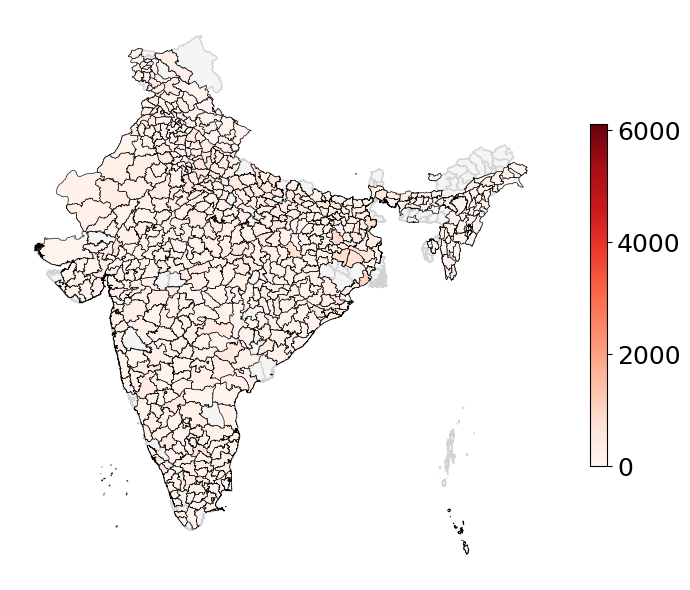

In [ ]:
plot_plastic_choropleth('india', plastic_median_subset, gadm_subset)

In [ ]:
def plot_global_plastic_choropleth(plastic_df, gadm_df, value_col='plas_litter_em'):
    # Ensure string types
    plastic_df = plastic_df.copy()
    plastic_df['adm_0_name'] = plastic_df['adm_0_name'].astype(str)
    plastic_df['adm_2_name'] = plastic_df['adm_2_name'].astype(str)
    gadm_df['adm_0_name'] = gadm_df['adm_0_name'].astype(str)
    gadm_df['adm_2_name'] = gadm_df['adm_2_name'].astype(str)

    geometries = []
    for idx, row in plastic_df.iterrows():
        country = row['adm_0_name']
        muni = row['adm_2_name']

        # Get gadm candidates for the same country
        gadm_country = gadm_df[gadm_df['adm_0_name'].str.lower() == country.lower()]
        matches = get_close_matches(muni, gadm_country['adm_2_name'], n=1)

        if matches:
            geom = gadm_country[gadm_country['adm_2_name'] == matches[0]].geometry.values[0]
        else:
            geom = None

        geometries.append(geom)

    # Attach geometries to plastic data
    plastic_df['geometry'] = geometries
    gdf = gpd.GeoDataFrame(plastic_df, geometry='geometry')
    gdf = gdf[gdf.geometry.notna() & gdf.is_valid]

    # Plot
    fig, ax = plt.subplots(figsize=(22, 14))
    gadm_df[gadm_df.geometry.notna() & gadm_df.is_valid].plot(
        ax=ax, color='whitesmoke', edgecolor='lightgrey', linewidth=0.2
    )

    gdf.plot(
        column=value_col,
        cmap='Reds',
        edgecolor='black',
        ax=ax,
        legend=True,
        linewidth=0.3,
        legend_kwds={"shrink": 0.6},
        vmin=0,
        vmax=plastic_df[value_col].max()
    )

    # ax.set_title("🌍 Global Plastic Litter Emission by Municipality", fontsize=18)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"global_plastic_emission_by_municipality.pdf"), format='pdf', dpi=3000)
    plt.show()


In [ ]:
# plot_global_plastic_choropleth(plastic_median_subset, gadm_subset)

No duplicates

In [ ]:
plastic_median_subset[['adm_0_name', 'adm_1_name', 'adm_2_name']].duplicated().sum()

0

In [ ]:
plastic_median_subset.shape

(42660, 63)

In [ ]:
plastic_median_countries = set(plastic_median_subset["adm_0_name"].dropna().unique())
plastic_median_regions = set(plastic_median_subset["adm_1_name"].dropna().unique())
plastic_median_municipals = set(plastic_median_subset["adm_2_name"].dropna().unique())

print(len(plastic_median_countries), len(plastic_median_regions), len(plastic_median_municipals))

246 16 41202


In [ ]:
(plastic_median_subset == 0).sum()

adm_0_name                     0
ISO3                           0
Income_cat                     0
adm_1_name                     0
adm_2_name                     0
                           ...  
plas_inf_ob_em_pct_em      17122
plas_form_deb_em_pct_em    41899
plas_form_ob_em_pct_em     41899
people_no_col              10681
people_no_col_pct_pop      10681
Length: 63, dtype: int64

Shape of the plastic dataset (plastic_median_subset.shape) is greater than the unique municipal names

In [ ]:
plastic_median_subset["adm_2_name"].str.lower().value_counts().head(20)
# Group by municipality and count distinct countries
shared = plastic_median_subset.groupby('adm_2_name')['adm_0_name'].nunique()
shared = shared[shared > 1].index

# Filter the original DataFrame to only shared municipalities and show countries
shared_munis = plastic_median_subset[plastic_median_subset['adm_2_name'].isin(shared)]
shared_munis = shared_munis[['adm_2_name', 'adm_0_name']].drop_duplicates().sort_values(by='adm_2_name')

shared_munis.reset_index(drop=True, inplace=True)
shared_munis.head(10)

adm_2_name                        adm_0_name
0        aba                           hungary
1        aba                             china
2        aba  democratic republic of the congo
3      abala                            mexico
4      abala                 republic of congo
5  abbeville                            france
6  abbeville          united states of america
7     abidos                            brazil
8     abidos                          portugal
9    acevedo                          colombia

In [ ]:
plastic_median_regions

{'canada',
 'china',
 'eurasia',
 'india',
 'latin america',
 'middle east and north africa',
 'oecd eu countries',
 'oecd noneu countries',
 'oecd oceania',
 'oecd pacific',
 'other africa',
 'other eu',
 'other eurasia',
 'other nonoecd asia',
 'other oecd america',
 'usa'}

In [ ]:
#  #Standardize location names
# def clean_location(name):
#     if pd.isna(name):  # Handle NaN values
#         return name
#     name = name.strip().lower()  # Convert to lowercase and remove extra spaces
#     name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("utf-8")  # Remove accents
#     name = re.sub(r"\bprovince of\b", "", name)
#     name = re.sub(r"\btownship\b|\bdist\b|\bcd\b", "", name)
#     name = re.sub(r"\bcity of\b", "", name)
#     name = re.sub(r"[^a-z\s]", "", name)
#     name = re.sub(r"\s+", " ", name)
#     return name.strip()

# # Apply the updated cleaning function
# plastic_median_subset["adm_1_name"] = plastic_median_subset["adm_1_name"].astype(str).apply(clean_location)
# plastic_median_subset["adm_2_name"] = plastic_median_subset["adm_2_name"].astype(str).apply(clean_location)
# plastic_median_subset["adm_0_name"] = plastic_median_subset["adm_0_name"].astype(str).apply(clean_location)


# # Ensure dengue dataset adm_2_name is string
# plastic_median_subset["adm_2_name"] = plastic_median_subset["adm_2_name"].astype(str)


# plastic_median_subset.head(2)

Show  municipalities with highest plastic litter emission

In [ ]:
def rank_top_emitters(df, sort_by, columns=None, top_n=10, ascending=False):

    if columns is None:
        columns = df.columns
    return df.sort_values(sort_by, ascending=ascending)[columns].head(top_n)

# Top 10 emitters by plastic litter emission
rank_top_emitters(
    plastic_median_subset, sort_by="plas_litter_em",
    columns=["adm_0_name", "adm_2_name", "plas_litter_em", "plas_em_per_cap" ],
    top_n=10)

adm_0_name     adm_2_name  plas_litter_em  \
12375  democratic republic of the congo       kinshasa     6112.720261   
38513                          tanzania  dar es salaam     4936.226909   
38560                            uganda    kampala gma     4294.483489   
9954                              china      chongqing     3297.740049   
20790                             india          delhi     2578.921126   
29020                           nigeria          lagos     2450.949152   
30332                          pakistan     faisalabad     2319.512993   
12370  democratic republic of the congo      mbujimayi     2085.457288   
30382                          pakistan        karachi     2024.317335   
9953                              china        beijing     1939.987829   

       plas_em_per_cap  
12375        12.412876  
38513        16.665182  
38560        19.895965  
9954          1.935721  
20790         8.743114  
29020        22.810929  
30332        11.141333  
12370        13.504481  
30382         7.869640  
9953          0.807449

Show countries with highest plastic litter emission

In [ ]:
def rank_country_totals(df, group_by="adm_0_name", value_col="plas_litter_em", top_n=10, aggfunc=None):
    agg = aggfunc or ("mean" if "per_cap" in value_col.lower() else "sum")
    return df.groupby(group_by)[value_col].agg(agg).nlargest(top_n).reset_index()

# rank_country_totals(plastic_median_subset, value_col="plas_em_per_cap")
rank_country_totals(plastic_median_subset, value_col="plas_litter_em")

adm_0_name  plas_litter_em
0                             india   264334.925622
1                             china   157398.661224
2                         indonesia    68150.703298
3                           nigeria    65618.611830
4                          pakistan    62379.600914
5  democratic republic of the congo    49617.142695
6                        bangladesh    46621.095036
7                          ethiopia    38673.773554
8                          tanzania    33527.687226
9                            brazil    33329.627246

Top countries with most municipalities

In [ ]:
# Top countries with most municipalities in data
print("\n Top 10 Countries by Municipality Count:")
plastic_median_subset["adm_0_name"].value_counts().head(10)


 Top 10 Countries by Municipality Count:


adm_0_name
brazil                      5209
russia                      2226
china                       2171
india                       2086
united states of america    1835
mexico                      1699
japan                       1641
philippines                 1402
colombia                     981
thailand                     859
Name: count, dtype: int64

Check for Columns with NaN Values

In [ ]:
plastic_median_subset.isna().sum()

adm_0_name                 0
ISO3                       0
Income_cat                 0
adm_1_name                 0
adm_2_name                 0
                          ..
plas_inf_ob_em_pct_em      0
plas_form_deb_em_pct_em    0
plas_form_ob_em_pct_em     0
people_no_col              0
people_no_col_pct_pop      0
Length: 63, dtype: int64

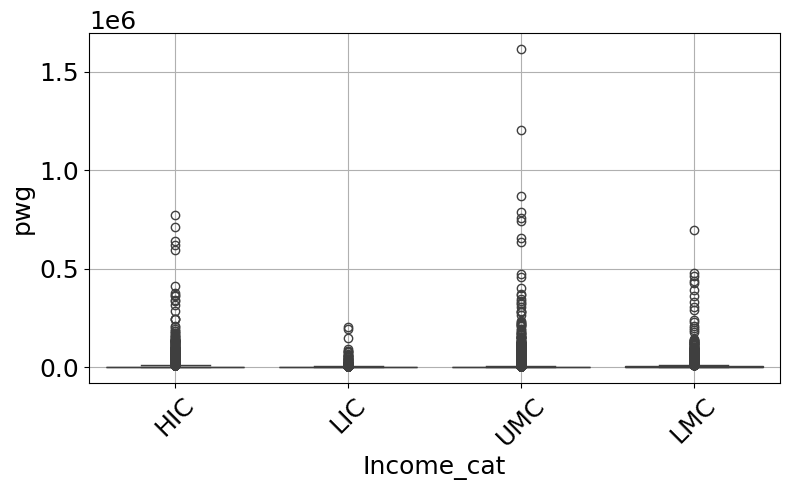

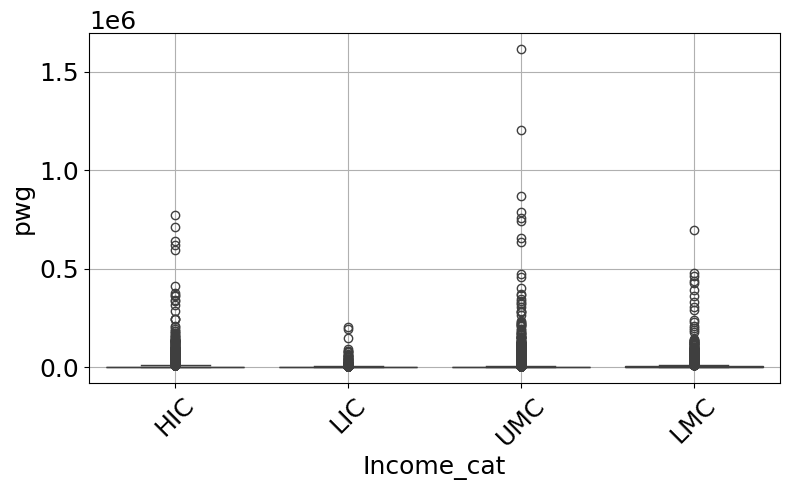

In [ ]:
def plot_box_by_group(df, x_col="Income_cat", y_col="pwg", title=None):

    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=x_col, y=y_col)
    # plt.title(title or f"{y_col} by {x_col}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"{y_col} by {x_col}.pdf"), format='pdf', dpi=3000)
    plt.show()

plot_box_by_group(plastic_median_subset, y_col="pwg")
plot_box_by_group(plastic_median_subset, y_col="pwg")

Plastic litter emissions vary by income category. High-income countries tend to have lower and more consistent emissions, both in total and per capita. In contrast, lower- and middle-income countries exhibit higher emissions with greater variability, possibly due to differences in waste management infrastructure and population density

## Compare the the municipalities in the plastic litter  dataset and the dengue dataset

Correct inconsistencies in municipal and country names between the dengue and plastic dataset

In [ ]:
# Load the file
dengue_merged_gdf = gpd.read_file(f"{data_folder}/dengue_preprocessed_main.gpkg")

# Reproject to World Mollweide (suitable for global area-preserving calculations)
dengue_projected = dengue_merged_gdf.to_crs(epsg=3857)

# Compute centroids in projected space
dengue_projected["centroid"] = dengue_projected.geometry.centroid

# Create GeoDataFrame from centroids and reproject back to EPSG:4326
dengue_projected = dengue_projected.set_geometry("centroid")
dengue_centroids = dengue_projected.to_crs(epsg=4326)

# Extract Point geometry back into original GeoDataFrame
dengue_merged_gdf["centroid"] = dengue_centroids.geometry

dengue_merged_gdf.head()

adm_0_name    adm_1_name       adm_2_name  mean_dengue_2014_2023  \
0  argentina  buenos aires  almirante brown              61.500000   
1  argentina  buenos aires       avellaneda             360.000000   
2  argentina  buenos aires             azul               2.000000   
3  argentina  buenos aires     bahia blanca               3.000000   
4  argentina  buenos aires      berazategui              96.333333   

        GID_2                                           geometry  \
0   ARG.1.4_1  MULTIPOLYGON (((-58.39741 -34.91209, -58.40034...   
1   ARG.1.7_1  MULTIPOLYGON (((-58.33411 -34.73055, -58.33783...   
2   ARG.1.9_1  MULTIPOLYGON (((-59.49092 -36.23094, -59.2936 ...   
3  ARG.1.10_1  MULTIPOLYGON (((-62.21736 -38.83569, -62.21625...   
4  ARG.1.14_1  MULTIPOLYGON (((-58.19181 -34.73733, -58.19125...   

                      centroid  
0  POINT (-58.36831 -34.83864)  
1  POINT (-58.34009 -34.68142)  
2  POINT (-59.69994 -36.79136)  
3  POINT (-62.16959 -38.58023)  
4  POINT (-58.15472 -34.81923)

In [ ]:
dengue_merged_gdf.shape

(6669, 7)

In [ ]:
countries_dengue = set(dengue_merged_gdf["adm_0_name"].unique())
countries_plastic = set(plastic_median_subset["adm_0_name"].unique())

In [ ]:
matched_municipals_by_country = {}

for country in countries_dengue:
    dengue_muni = set(dengue_merged_gdf.loc[dengue_merged_gdf['adm_0_name'] == country, 'adm_2_name'])
    plastic_muni = set(plastic_median_subset.loc[plastic_median_subset['adm_0_name'] == country, 'adm_2_name'])

    matched = dengue_muni & plastic_muni  # Set intersection: matched municipalities
    matched_municipals_by_country[country] = (len(matched), sorted(matched))

for country in countries_dengue:
    print(f"🔍 {matched_municipals_by_country[country][0]} already matched municipalities with Dengue in '{country}'...")

🔍 15 already matched municipalities with Dengue in 'china'...
🔍 3550 already matched municipalities with Dengue in 'brazil'...
🔍 102 already matched municipalities with Dengue in 'peru'...
🔍 31 already matched municipalities with Dengue in 'united states of america'...
🔍 179 already matched municipalities with Dengue in 'argentina'...
🔍 614 already matched municipalities with Dengue in 'colombia'...
🔍 61 already matched municipalities with Dengue in 'costa rica'...
🔍 7 already matched municipalities with Dengue in 'pakistan'...


In [ ]:
# Check unmatched
unmatched_dengue = set(dengue_merged_gdf['adm_2_name'].unique()) - set(plastic_median_subset['adm_2_name'].unique())
print(f"\n Unmatched dengue municipals : {len(unmatched_dengue)}")
# if unmatched_dengue:
#     for m in sorted(unmatched_dengue):
#         print(f"- {m}")



 Unmatched dengue municipals : 1669


In [ ]:
replacement_map = {}

for country in countries_dengue:
    dengue_muni = set(dengue_merged_gdf.loc[dengue_merged_gdf['adm_0_name'] == country, 'adm_2_name'])
    plastic_muni = set(plastic_median_subset.loc[plastic_median_subset['adm_0_name'] == country, 'adm_2_name'])

    unmatched = dengue_muni - plastic_muni  # dengue names not in plastic
    matched = dengue_muni & plastic_muni
    plastic_candidates = plastic_muni - matched       # names in plastic to match against which have not ALREADY BEEN MATCHED
    print(f"🔍 {len(unmatched)} unmatched municipalities in '{country}'...")

    for muni in unmatched:
        if plastic_candidates:
            result = process.extractOne(muni, plastic_candidates, score_cutoff=80)
            if result:
                best_match, score = result
                replacement_map[(best_match, country)] = muni  # replace in plastic with dengue name


🔍 6 unmatched municipalities in 'china'...
🔍 1399 unmatched municipalities in 'brazil'...
🔍 16 unmatched municipalities in 'peru'...
🔍 0 unmatched municipalities in 'united states of america'...
🔍 56 unmatched municipalities in 'argentina'...
🔍 241 unmatched municipalities in 'colombia'...
🔍 13 unmatched municipalities in 'costa rica'...
🔍 1 unmatched municipalities in 'pakistan'...


In [ ]:
changes = []

def apply_fuzzy_replacement(row):
    key = (row['adm_2_name'], row['adm_0_name'])
    if key in replacement_map:
        new_value = replacement_map[key]
        if row['adm_2_name'] != new_value:
            print(f"✅ Replacing '{row['adm_2_name']}' with '{new_value}' in {row['adm_0_name'].title()}")
            changes.append({
                'adm_0_name': row['adm_0_name'],
                'adm_2_name': row['adm_2_name'],
                'adm_2_name_new': new_value
            })
        return new_value
    return row['adm_2_name']

# Apply fuzzy replacements and track changes
plastic_median_subset['adm_2_name'] = plastic_median_subset.apply(apply_fuzzy_replacement, axis=1)

# Convert logged changes to DataFrame
matched_plastic_median_subset = pd.DataFrame(changes)

✅ Replacing 'bahaa blanca' with 'bahia blanca' in Argentina
✅ Replacing 'caauelas' with 'canuelas' in Argentina
✅ Replacing 'colan' with 'colon' in Argentina
✅ Replacing 'esteban echeverraa' with 'esteban echeverria' in Argentina
✅ Replacing 'exaltacian de la cruz' with 'exaltacion de la cruz' in Argentina
✅ Replacing 'general pueyrredan' with 'general pueyrredon' in Argentina
✅ Replacing 'general rodraguez' with 'general rodriguez' in Argentina
✅ Replacing 'general san martan' with 'general san martin' in Argentina
✅ Replacing 'junan' with 'junin' in Argentina
✅ Replacing 'moran' with 'moron' in Argentina
✅ Replacing 'olavarraa' with 'olavarria' in Argentina
✅ Replacing 'san andras de giles' with 'san andres de giles' in Argentina
✅ Replacing 'vicente lapez' with 'vicente lopez' in Argentina
✅ Replacing 'antofagasta de la sierra' with 'la vina' in Argentina
✅ Replacing 'belan' with 'belen' in Argentina
✅ Replacing 'fray mamerto esquiao' with 'fray mamerto esquiu' in Argentina
✅ Replac

In [ ]:
# Check unmatched
unmatched_dengue = set(dengue_merged_gdf['adm_2_name'].unique()) - set(plastic_median_subset['adm_2_name'].unique())
print(f"\n Unmatched dengue municipals : {len(unmatched_dengue)}")


 Unmatched dengue municipals : 275


In [ ]:
brazil_maps  = {
    'abaara' : 'abare',
    'aau' : 'acu',
    'acaraao' : 'acarau',
    'agrona mica' : 'agronomica',
    'angalica' : 'angelica',
    'araau': 'aracu',
    'araauaa' :   'aracuai',
    'armaaao dos baozios': 'armacao dos baozios',
    'avaa':  'avai',
    'baga' :    'bage',
    'baaa da traiaao':  'baia da traicao',
    'banzaaa' : 'banzae',
    'brasalia' : 'brasilia',
    'brasapolis' : 'brazopolis',
    'caeta' : 'caetanopolis',
    'caiaara' : 'caicara',
    'camba' : 'cambe',
    'caraa' : 'carai',
    'caraaobas' : 'caraubas',
    'caririaaao' : 'caririacu',
    'cipa' : 'cipo',
    'coda' : 'codo',
    'cola nia do piaua' : 'colonia do piaui',
    'conceiaao' : 'conceicao',
    'conceiaao do almeida' : 'conceicao da barra de minas',
    'conceiaao do coita' : 'conceicao do coite',
    'coreaao' : 'coreau',
    'ereraa' : 'erere',
    'faanix' : 'fenix',
    'grajaao' : 'grajau',
    'guaaua' : 'guaira',
    'guaaua' : 'guaiba',
    'guaiaara' : 'guaicara',
    'guapa' : 'guape',
    'guaraaaa' : 'guarai',
    'iaau' : 'iapu',
    'ibiaaa' : 'ibiai',
    'coda' : 'ibiaaa',
    'icapua' : 'icapui',
    'icam' : 'icem',
    'icaraama' : 'icaraima',
    'igaraau do tietaa' : 'igaracu do tiete',
    'iguaa' : 'iguai',
    'iguaraau' : 'iguaracu',
    'ijua' : 'ijui',
    'ipiaao' : 'ipiau',
    'irecaa' : 'irece',
    'irineapolis' : 'indianopolis',
    'irineapolis' : 'itaiopolis',
    'itapa' : 'itape',
    'itiaoba' : 'itauba',
    'iuiao' : 'iuna',
    'ivaa' : 'ivai',
    'jaboticabal' : 'jaboticabal',
    'jacaraao' : 'jacarei',
    'janaaoba' : 'janauba',
    'juana' : 'jau',
    'jiquiriaa' : 'jiquirica',
    'lenaais' : 'lencois',
    'maracanaao' : 'maracanau',
    'maraao' : 'marau',
    'massapaa' : 'massape do piaui',
    'mateira' : 'matureia',
    'mercaas' : 'merces',
    'monaaes' : 'moncoes',
    'mucugaa' : 'mucuge',
    'oras' : 'oros',
    'paiaandu' : 'paicandu',
    'pajeao do piaua' : 'pajeu do piaui',
    'pao de aaaocar' : 'pao de acucar',
    'paraao' : 'parau',
    'passabam' : 'passagem',
    'perdaes' : 'perdoes',
    'piaarra' : 'picarra',
    'piaan' : 'pien',
    'poaao' : 'pocao',
    'poaaes' : 'pocoes',
    'pota' : 'pote',
    'santa ma nica' : 'santa monica',
    'santo anta nio do iaa' : 'santo antonio do ica',
    'santo anta nio' : 'santo antonio',
    'serida' : 'santana do serido',
    'seropadica' : 'seropedica',
    'taiaau' : 'taiacu',
    'tefa' : 'tefe',
    'tietaa' : 'tiete',
    'traas coraaaes' : 'tres coracoes',
    'ubaa' : 'ubai',
    'unaa' : 'unai',
    'uruaau' : 'urucui',
    'urupaas' : 'urupes',
    'veraa' : 'vere',
    'xambraa' : 'xambre',
    'zabelaa' : 'zabele'
}

colombia_maps = {
    'apaa' : 'apia',
    'carurao': 'caruru',
    'el penon': 'el penol',
    'itagaa':'itagui',
    'jesaos maraa': 'jesus maria',
    'la peaa': 'la pena',
    'mapiripan': 'mapiripana',
    'mitao': 'mitu',
    'pula':'puli',
    'sipa':'sipi',
    'sopa':'sopo',
    'yala': 'yali'
}

argentina_maps = {
    'iguazao': 'iguazu',
    'junan': 'junin',
    'lanaos': 'lanus',
    'maipao': 'maipu',
}

costarica_maps = {
    'escazao' : 'escazu'
    }

peru_maps = {
    "jaan": "jaen",
    "maraaan": "maranon",
    "puraos": "purus"
}

# Combine all mapping dictionaries into one
country_maps = {
    'brazil': brazil_maps,
    'costa rica': costarica_maps,
    'colombia': colombia_maps,
    'peru': peru_maps,
    'argentina': argentina_maps
}

# Loop through each country and apply replacements
for country, mapping in country_maps.items():
    mask = plastic_median_subset["adm_0_name"].str.lower() == country
    plastic_median_subset.loc[mask, "adm_2_name"] = (
        plastic_median_subset.loc[mask, "adm_2_name"].replace(mapping)
    )

In [ ]:
# Check unmatched
unmatched_dengue = set(dengue_merged_gdf['adm_2_name'].unique()) - set(plastic_median_subset['adm_2_name'].unique())
print(f"\n Unmatched dengue municipals : {len(unmatched_dengue)}")


 Unmatched dengue municipals : 193


In [ ]:
unmatched_municipals_by_country = {}

for country in countries_dengue:
    dengue_muni = set(dengue_merged_gdf.loc[dengue_merged_gdf['adm_0_name'] == country, 'adm_2_name'])
    plastic_muni = set(plastic_median_subset.loc[plastic_median_subset['adm_0_name'] == country, 'adm_2_name'])

    unmatched = dengue_muni - plastic_muni  # Set intersection: matched municipalities
    unmatched_municipals_by_country[country] = (len(unmatched), sorted(unmatched))

for country in countries_dengue:
    print(f"🔍 {unmatched_municipals_by_country[country][0]} unmatched municipalities with Dengue in '{country}'...")

🔍 0 unmatched municipalities with Dengue in 'china'...
🔍 153 unmatched municipalities with Dengue in 'brazil'...
🔍 0 unmatched municipalities with Dengue in 'peru'...
🔍 0 unmatched municipalities with Dengue in 'united states of america'...
🔍 0 unmatched municipalities with Dengue in 'argentina'...
🔍 47 unmatched municipalities with Dengue in 'colombia'...
🔍 0 unmatched municipalities with Dengue in 'costa rica'...
🔍 0 unmatched municipalities with Dengue in 'pakistan'...


In [ ]:
new_unmatched_municipalities_by_country = {}
for key, values in unmatched_municipals_by_country.items():
    if values[0] != 0:
        new_unmatched_municipalities_by_country[key] = values
new_unmatched_municipalities_by_country

{'brazil': (153,
  ['abaira',
   'apore',
   'apui',
   'areiopolis',
   'aroeiras do itaim',
   'bagre',
   'balneario picarras',
   'barra do choca',
   'barrocas',
   'belem do piaui',
   'bodoco',
   'bom jesus do araguaia',
   'borrazopolis',
   'britania',
   'brodowski',
   'cacule',
   'caem',
   'campo ere',
   'campo largo',
   'campos de julio',
   'campos dos goytacazes',
   'cana verde',
   'caraubas do piaui',
   'carire',
   'carius',
   'codo',
   'coite do noia',
   'colniza',
   'conceicao do caninde',
   'conceicao do lagoacu',
   'conquista doeste',
   'couto de magalhaes de minas',
   'cruzaltense',
   'cruzilia',
   'curuca',
   'curvelandia',
   'damolandia',
   'dois irmaos do tocantins',
   'embu das artes',
   'figueirao',
   'florinea',
   'gameleira de goias',
   'governador lindenberg',
   'graca',
   'gravatai',
   'grossos',
   'guacui',
   'guaira',
   'guaiuba',
   'iacu',
   'ibicare',
   'ibicui',
   'icapui',
   'ico',
   'iepe',
   'igaracy',
   'ig

In [ ]:
# Check unmatched
unmatched_plastic = set(plastic_median_subset['adm_2_name'].unique()) - set(dengue_merged_gdf['adm_2_name'].unique())
print(f"\n Unmatched plastic municipals : {len(unmatched_plastic)}")
# if unmatched_plastic:
#     for m in sorted(unmatched_plastic):
#         print(f"- {m}")



 Unmatched plastic municipals : 35211


In [ ]:
# Step 1: Create plastic subset with matched municipalities
plastic_matched_only = plastic_median_subset[
    ~plastic_median_subset['adm_2_name'].isin(unmatched_plastic)
].copy()

# Step 2: Confirm the result
print(f"Original plastic rows: {len(plastic_median_subset)}")
print(f"Matched plastic rows: {len(plastic_matched_only)}")


Original plastic rows: 42660
Matched plastic rows: 6666


In [ ]:
plastic_median_countries = set(plastic_matched_only["adm_0_name"].dropna().unique())
plastic_median_regions = set(plastic_matched_only["adm_1_name"].dropna().unique())
plastic_median_municipals = set(plastic_matched_only["adm_2_name"].dropna().unique())

print(len(plastic_median_countries), len(plastic_median_regions), len(plastic_median_municipals))


61 14 5993


In [ ]:
plastic_matched_only.shape

(6666, 63)

In [ ]:
plastic_matched_only.head()

adm_0_name ISO3 Income_cat     adm_1_name       adm_2_name     Unique_ID  \
466    albania  ALB        UMC  other eurasia            tunja  ALB.4.2.10_1   
491    albania  ALB        UMC  other eurasia            patos  ALB.5.1.10_1   
732  argentina  ARG        UMC  latin america  almirante brown     ARG.1.4_1   
735  argentina  ARG        UMC  latin america       avellaneda     ARG.1.7_1   
737  argentina  ARG        UMC  latin america             azul     ARG.1.9_1   

     Population_2020  Rural_share  Deg_Urban_Lv1  Deg_Urban_Lv2  ...  \
466       811.362916     1.000000              1             11  ...   
491     11627.610361     0.252560              2             23  ...   
732    560097.564993     0.003252              3             30  ...   
735    399825.426948     0.001051              3             30  ...   
737     74203.968586     0.213579              3             30  ...   

     plas_uncol_ob_em_pct_em  plas_collection_deb_em_pct_em  \
466                74.785637                       0.971769   
491                57.651149                       3.222543   
732                53.422388                       1.814674   
735                52.430868                       2.471172   
737                60.252874                       1.659411   

     plas_disp_deb_em_pct_em  plas_disp_ob_em_pct_em  plas_inf_deb_em_pct_em  \
466                 0.011202                0.343275                0.000000   
491                 0.008632                0.459895                0.359511   
732                 0.000382                0.021239                0.058559   
735                 0.000000                0.000000                0.046689   
737                 0.006501                0.316862                0.215094   

     plas_inf_ob_em_pct_em  plas_form_deb_em_pct_em  plas_form_ob_em_pct_em  \
466               0.000000                      0.0                     0.0   
491               0.713340                      0.0                     0.0   
732               0.090610                      0.0                     0.0   
735               0.073099                      0.0                     0.0   
737               0.412950                      0.0                     0.0   

     people_no_col  people_no_col_pct_pop  
466     416.906541              51.383485  
491    1536.135307              13.211101  
732   34990.319466               6.247183  
735    9760.323288               2.441146  
737   12513.923624              16.864224  

[5 rows x 63 columns]

### Match GADM geometries to plastic data

In [ ]:
# Merge plastic data with GADM geometries
plastic_with_geom = plastic_median_subset.drop(columns=["adm_1_name"]).merge(
    gadm_subset[['adm_0_name', 'adm_1_name', 'adm_2_name', 'GID_2', 'geometry']],
    on=['adm_0_name', 'adm_2_name'],
    how='inner'
)

plastic_with_geom = plastic_with_geom[['adm_0_name', 'ISO3', 'Income_cat', 'adm_1_name', 'adm_2_name', 'Unique_ID', 'GID_2',
       'Population_2020', 'Rural_share', 'Deg_Urban_Lv1', 'Deg_Urban_Lv2',
       'wg', 'wg_per_cap', 'pwg', 'pwg_per_cap', 'col_cov_pct_gen_exc_lit',
       'col_del_pct_gen', 'litter_em_pct_gen', 'uncol_em_pct_gen',
       'collection_em_pct_gen', 'cont_disp_pct_gen', 'uncont_disp_pct_gen',
       'compost_pct_gen', 'incin_pct_gen', 'open_burn_MSW',
       'open_burn_MSW_pct_gen', 'plas_debris_em', 'plas_burn_em', 'plas_em',
       'plas_debris_em_pct_em', 'plas_burn_em_pct_em',
       'plas_debris_em_per_cap', 'plas_burn_em_per_cap', 'plas_em_per_cap',
       'rigid_plas_deb_em', 'flex_plas_deb_em', 'rigid_plas_ob_em',
       'flex_plas_ob_em', 'rigid_plas_deb_em_pct_em',
       'flex_plas_deb_em_pct_em', 'rigid_plas_ob_em_pct_em',
       'flex_plas_ob_em_pct_em', 'plas_litter_em', 'plas_uncol_em',
       'plas_collection_em', 'plas_disp_em', 'plas_recy_em',
       'plas_litter_em_pct_em', 'plas_uncol_em_pct_em',
       'plas_collection_em_pct_em', 'plas_disp_em_pct_em',
       'plas_recy_em_pct_em', 'plas_litter_deb_em_pct_em',
       'plas_uncol_deb_em_pct_em', 'plas_uncol_ob_em_pct_em',
       'plas_collection_deb_em_pct_em', 'plas_disp_deb_em_pct_em',
       'plas_disp_ob_em_pct_em', 'plas_inf_deb_em_pct_em',
       'plas_inf_ob_em_pct_em', 'plas_form_deb_em_pct_em',
       'plas_form_ob_em_pct_em', 'people_no_col', 'people_no_col_pct_pop', 'geometry']]

# Convert to GeoDataFrame
plastic_gdf = gpd.GeoDataFrame(plastic_with_geom, geometry='geometry')

# Reproject to World Mollweide (suitable for global area-preserving calculations)
plastic_gdf_projected = plastic_gdf.to_crs(epsg=3857)

# Compute centroids in projected space
plastic_gdf_projected["centroid"] = plastic_gdf_projected.geometry.centroid

# Create GeoDataFrame from centroids and reproject back to EPSG:4326
plastic_gdf_projected = plastic_gdf_projected.set_geometry("centroid")
plastic_gdf_centroids = plastic_gdf_projected.to_crs(epsg=4326)

# Extract Point geometry back into original GeoDataFrame
plastic_gdf["centroid"] = plastic_gdf_centroids.geometry

plastic_gdf.head(3)

adm_0_name ISO3 Income_cat  adm_1_name adm_2_name  Unique_ID      GID_2  \
0  afghanistan  AFG        LIC  badakhshan    baharak  AFG.1.1_1  AFG.1.1_1   
1  afghanistan  AFG        LIC  badakhshan     darwaz  AFG.1.2_1  AFG.1.2_1   
2  afghanistan  AFG        LIC  badakhshan   fayzabad  AFG.1.3_1  AFG.1.3_1   

   Population_2020  Rural_share  Deg_Urban_Lv1  ...  plas_disp_deb_em_pct_em  \
0    157502.783611     0.196370              2  ...                 0.338751   
1    112779.063043     0.333908              2  ...                 0.315311   
2    459501.868941     0.101773              3  ...                 0.350784   

   plas_disp_ob_em_pct_em  plas_inf_deb_em_pct_em  plas_inf_ob_em_pct_em  \
0               14.131522                1.560970               0.640956   
1               12.649351                1.679379               0.581550   
2               16.116949                1.327949               0.602050   

   plas_form_deb_em_pct_em  plas_form_ob_em_pct_em  people_no_col  \
0                      0.0                     0.0   55618.435965   
1                      0.0                     0.0   44685.392670   
2                      0.0                     0.0  148659.619429   

   people_no_col_pct_pop                                           geometry  \
0              35.312669  MULTIPOLYGON (((71.41149 36.55717, 71.40954 36...   
1              39.622064  MULTIPOLYGON (((71.2762 38.00465, 71.27578 38....   
2              32.352343  MULTIPOLYGON (((70.78272 37.27678, 70.78635 37...   

                    centroid  
0   POINT (71.10439 37.0221)  
1  POINT (70.93919 38.21125)  
2  POINT (70.47054 37.11547)  

[3 rows x 66 columns]

Find  missing geometries

In [ ]:
plastic_gdf.isna().sum()

adm_0_name                0
ISO3                      0
Income_cat                0
adm_1_name                0
adm_2_name                0
                         ..
plas_form_ob_em_pct_em    0
people_no_col             0
people_no_col_pct_pop     0
geometry                  0
centroid                  0
Length: 66, dtype: int64

In [ ]:
plastic_gdf.shape

(32017, 66)

In [ ]:
def plot_plastic_choropleth(country_name, plastic_gdf, gadm_subset, value_col='plas_litter_em'):

    # Step 1: Filter plastic data for country
    country_df = plastic_gdf[plastic_gdf['adm_0_name'].str.lower() == country_name.lower()].copy()

    # Step 2: Group by municipality, aggregate plastic emission and keep one geometry
    grouped = country_df.groupby('adm_2_name').agg({
        value_col: 'sum',
        'geometry': 'first'
    }).reset_index()

    gdf = gpd.GeoDataFrame(grouped, geometry='geometry')

    # Step 3: Clean geometries
    gdf = gdf[gdf['geometry'].notnull()]
    gdf = gdf[gdf.is_valid]

    # Step 4: Get country geometry for bounding box
    country_boundary = gadm_subset[gadm_subset['adm_0_name'].str.lower() == country_name.lower()]
    minx, miny, maxx, maxy = country_boundary.total_bounds
    gdf = gdf.cx[minx:maxx, miny:maxy]

    # Step 5: Get full municipal boundaries from GADM for context
    base = country_boundary.copy()
    base = base[base['geometry'].notnull() & base.is_valid]

    # Step 6: Plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot base map
    base.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey', linewidth=0.4)

    # Plot plastic emission overlay
    gdf.plot(
        column=value_col,
        cmap='Reds',
        linewidth=0.4,
        edgecolor='black',
        legend=True,
        ax=ax,
        legend_kwds={"shrink": 0.6}
    )

    # ax.set_title(f"Total Plastic Litter Emission by Municipality in {country_name.title()}", fontsize=16)
    ax.axis("off")
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"plastic_litter_emission_by_muni_in_{country_name.lower}.pdf"), format='pdf', dpi=3000)
    plt.show()


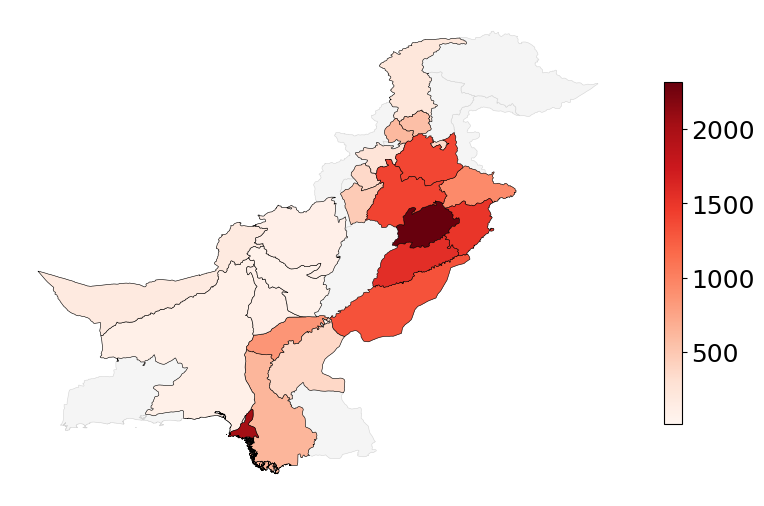

In [ ]:
plot_plastic_choropleth(
    country_name='pakistan',
    plastic_gdf=plastic_gdf,
    gadm_subset=gadm_subset
)

In [ ]:
plastic_gdf.crs
gadm_subset.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Ensure no missing values
plastic_ranked = plastic_gdf[plastic_gdf['plas_litter_em'].notna()].copy()

# Rank in descending order (1 = highest emission)
plastic_ranked['plastic_rank'] = plastic_ranked['plas_litter_em'].rank(method='min', ascending=False).astype(int)

# Sort by rank
plastic_ranked = plastic_ranked.sort_values('plastic_rank')

# Optional: display top 5
plastic_ranked[['adm_0_name','adm_1_name', 'adm_2_name', 'plas_litter_em', 'plastic_rank']].head(20)

adm_0_name     adm_1_name    adm_2_name  \
8250   democratic republic of the congo       kinshasa      kinshasa   
7898                              china      chongqing     chongqing   
20199                          pakistan         punjab    faisalabad   
8245   democratic republic of the congo  kasaioriental     mbujimayi   
20209                          pakistan          sindh       karachi   
7897                              china        beijing       beijing   
18097                        mozambique         maputo        maputo   
10897                          ethiopia    addis abeba   addis abeba   
7900                              china       shanghai      shanghai   
25575                           somalia       banaadir     mogadisho   
20202                          pakistan         punjab        multan   
20201                          pakistan         punjab        lahore   
12190                             haiti          ouest  portauprince   
146                         afghanistan          kabul         kabul   
20204                          pakistan         punjab      sargodha   
17664                              mali         bamako        bamako   
20203                          pakistan         punjab    rawalpindi   
8194   democratic republic of the congo    hautkatanga    lubumbashi   
31964                          zimbabwe         harare        harare   
12810                             india          bihar          gaya   

       plas_litter_em  plastic_rank  
8250      6112.720261             1  
7898      3297.740049             2  
20199     2319.512993             3  
8245      2085.457288             4  
20209     2024.317335             5  
7897      1939.987829             6  
18097     1768.937927             7  
10897     1765.484192             8  
7900      1761.396413             9  
25575     1692.347504            10  
20202     1561.975995            11  
20201     1502.931036            12  
12190     1496.007276            13  
146       1453.845266            14  
20204     1405.396395            15  
17664     1390.988096            16  
20203     1390.379769            17  
8194      1359.847293            18  
31964     1354.897260            19  
12810     1348.392171            20

In [ ]:
# Ensure no missing values
dengue_ranked = dengue_merged_gdf[dengue_merged_gdf['mean_dengue_2014_2023'].notna()].copy()

# Rank in descending order (1 = most dengue cases)
dengue_ranked['dengue_rank'] = dengue_ranked['mean_dengue_2014_2023'].rank(method='min', ascending=False).astype(int)

# Sort by rank
dengue_ranked = dengue_ranked.sort_values('dengue_rank')

# Optional: display top 5
dengue_ranked[['adm_0_name', 'adm_2_name', 'mean_dengue_2014_2023', 'dengue_rank']].head(20)

adm_0_name             adm_2_name  mean_dengue_2014_2023  dengue_rank
1875     brazil         belo horizonte              39518.000            1
1242     brazil                goiania              36785.250            2
5195     brazil              sao paulo              19859.625            3
4739     brazil               campinas              18923.250            4
5189     brazil  sao jose do rio preto              16357.625            5
1069     brazil               brasilia              15917.625            6
943      brazil              fortaleza              14765.625            7
1166     brazil   aparecida de goiania              12518.625            8
2011     brazil               contagem              11805.875            9
1881     brazil                  betim              11356.500           10
3520     brazil                 recife              10541.875           11
3855     brazil         rio de janeiro               9547.125           12
1750     brazil           campo grande               9364.125           13
3966     brazil                  natal               8594.500           14
2617     brazil             uberlandia               8333.875           15
5214     brazil               sorocaba               7986.875           16
5120     brazil         ribeirao preto               7429.125           17
5491      china              guangzhou               7136.500           18
2877     brazil            joao pessoa               6131.000           19
6615       peru                  piura               6072.300           20

In [ ]:
plastic_country_ranked = (
    plastic_gdf.dropna(subset=['plas_litter_em'])
    .groupby('adm_0_name')['plas_litter_em']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

plastic_country_ranked['plastic_rank'] = plastic_country_ranked['plas_litter_em'].rank(
    method='min', ascending=False).astype(int)
plastic_country_ranked.head(20)

adm_0_name  plas_litter_em  plastic_rank
0                              india    92322.654300             1
1                          indonesia    67075.337926             2
2                            nigeria    51793.442224             3
3   democratic republic of the congo    49581.534080             4
4                             brazil    34169.347443             5
5                             russia    29554.798665             6
6           united states of america    28999.904761             7
7                           tanzania    27244.611581             8
8                              china    26338.194618             9
9                        philippines    25850.519392            10
10                            uganda    24944.373728            11
11                          thailand    20961.788512            12
12                            mexico    19589.894731            13
13                       afghanistan    19166.779760            14
14                          pakistan    17720.879305            15
15                             egypt    16944.189367            16
16                           myanmar    15967.715422            17
17                        mozambique    14631.798959            18
18                             sudan    11739.197060            19
19                           ukraine    11579.628944            20

In [ ]:
dengue_country_ranked = (
    dengue_merged_gdf.dropna(subset=['mean_dengue_2014_2023'])
    .groupby('adm_0_name')['mean_dengue_2014_2023']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

dengue_country_ranked['dengue_rank'] = dengue_country_ranked['mean_dengue_2014_2023'].rank(
    method='min', ascending=False).astype(int)
dengue_country_ranked.head(20)

adm_0_name  mean_dengue_2014_2023  dengue_rank
0                    brazil          895834.904762            1
1                  colombia           59873.351587            2
2                      peru           41331.936111            3
3                 argentina           23595.250000            4
4                     china           16715.000000            5
5                costa rica           12558.367460            6
6  united states of america             858.000000            7
7                  pakistan             580.000000            8

Merge plastic and dengue

In [ ]:
# Merge plastic data with GADM geometries
plastic_dengue_merged = plastic_median_subset.drop(columns=["adm_1_name"]).merge(
    dengue_merged_gdf,
    on=['adm_0_name', 'adm_2_name'],
    how='inner'
)

plastic_dengue_merged = plastic_dengue_merged[['adm_0_name', 'ISO3', 'Income_cat', 'adm_1_name', 'adm_2_name', 'Unique_ID', 'GID_2',
       'Population_2020', 'Rural_share', 'Deg_Urban_Lv1', 'Deg_Urban_Lv2',
       'wg', 'wg_per_cap', 'pwg', 'pwg_per_cap', 'col_cov_pct_gen_exc_lit',
       'col_del_pct_gen', 'litter_em_pct_gen', 'uncol_em_pct_gen',
       'collection_em_pct_gen', 'cont_disp_pct_gen', 'uncont_disp_pct_gen',
       'compost_pct_gen', 'incin_pct_gen', 'open_burn_MSW',
       'open_burn_MSW_pct_gen', 'plas_debris_em', 'plas_burn_em', 'plas_em',
       'plas_debris_em_pct_em', 'plas_burn_em_pct_em',
       'plas_debris_em_per_cap', 'plas_burn_em_per_cap', 'plas_em_per_cap',
       'rigid_plas_deb_em', 'flex_plas_deb_em', 'rigid_plas_ob_em',
       'flex_plas_ob_em', 'rigid_plas_deb_em_pct_em',
       'flex_plas_deb_em_pct_em', 'rigid_plas_ob_em_pct_em',
       'flex_plas_ob_em_pct_em', 'plas_litter_em', 'plas_uncol_em',
       'plas_collection_em', 'plas_disp_em', 'plas_recy_em',
       'plas_litter_em_pct_em', 'plas_uncol_em_pct_em',
       'plas_collection_em_pct_em', 'plas_disp_em_pct_em',
       'plas_recy_em_pct_em', 'plas_litter_deb_em_pct_em',
       'plas_uncol_deb_em_pct_em', 'plas_uncol_ob_em_pct_em',
       'plas_collection_deb_em_pct_em', 'plas_disp_deb_em_pct_em',
       'plas_disp_ob_em_pct_em', 'plas_inf_deb_em_pct_em',
       'plas_inf_ob_em_pct_em', 'plas_form_deb_em_pct_em',
       'plas_form_ob_em_pct_em', 'people_no_col', 'people_no_col_pct_pop', 'mean_dengue_2014_2023', 'geometry']]

# Convert to GeoDataFrame
plastic_dengue_merged = gpd.GeoDataFrame(plastic_dengue_merged, geometry='geometry')

# Reproject to World Mollweide (suitable for global area-preserving calculations)
plastic_dengue_merged_projected = plastic_dengue_merged.to_crs(epsg=3857)

# Compute centroids in projected space
plastic_dengue_merged_projected["centroid"] = plastic_dengue_merged_projected.geometry.centroid

# Create GeoDataFrame from centroids and reproject back to EPSG:4326
plastic_dengue_merged_projected = plastic_dengue_merged_projected.set_geometry("centroid")
plastic_dengue_merged_centroids = plastic_dengue_merged_projected.to_crs(epsg=4326)

# Extract Point geometry back into original GeoDataFrame
plastic_dengue_merged["centroid"] = plastic_dengue_merged_centroids.geometry

plastic_dengue_merged.head(3)

adm_0_name ISO3 Income_cat    adm_1_name       adm_2_name  Unique_ID  \
0  argentina  ARG        UMC  buenos aires  almirante brown  ARG.1.4_1   
1  argentina  ARG        UMC         chaco  almirante brown  ARG.1.4_1   
2  argentina  ARG        UMC  buenos aires       avellaneda  ARG.1.7_1   

       GID_2  Population_2020  Rural_share  Deg_Urban_Lv1  ...  \
0  ARG.1.4_1    560097.564993     0.003252              3  ...   
1  ARG.3.1_1    560097.564993     0.003252              3  ...   
2  ARG.1.7_1    399825.426948     0.001051              3  ...   

   plas_disp_ob_em_pct_em  plas_inf_deb_em_pct_em  plas_inf_ob_em_pct_em  \
0                0.021239                0.058559               0.090610   
1                0.021239                0.058559               0.090610   
2                0.000000                0.046689               0.073099   

   plas_form_deb_em_pct_em  plas_form_ob_em_pct_em  people_no_col  \
0                      0.0                     0.0   34990.319466   
1                      0.0                     0.0   34990.319466   
2                      0.0                     0.0    9760.323288   

   people_no_col_pct_pop  mean_dengue_2014_2023  \
0               6.247183                   61.5   
1               6.247183                  657.0   
2               2.441146                  360.0   

                                            geometry  \
0  MULTIPOLYGON (((-58.39741 -34.91209, -58.40034...   
1  MULTIPOLYGON (((-60.79854 -26.42871, -60.91188...   
2  MULTIPOLYGON (((-58.33411 -34.73055, -58.33783...   

                      centroid  
0  POINT (-58.36831 -34.83864)  
1   POINT (-61.9843 -25.74921)  
2  POINT (-58.34009 -34.68142)  

[3 rows x 67 columns]

In [ ]:
plastic_dengue_merged.nunique()

adm_0_name                  8
ISO3                        8
Income_cat                  3
adm_1_name                118
adm_2_name               5987
                         ... 
people_no_col            6071
people_no_col_pct_pop    6071
mean_dengue_2014_2023    2683
geometry                 6456
centroid                 6456
Length: 67, dtype: int64

In [ ]:
plastic_median_subset[plastic_median_subset.adm_0_name=="united states of america"]

adm_0_name ISO3 Income_cat adm_1_name  adm_2_name  \
39286  united states of america  USA        HIC        usa     autauga   
39287  united states of america  USA        HIC        usa     baldwin   
39288  united states of america  USA        HIC        usa     barbour   
39289  united states of america  USA        HIC        usa        bibb   
39290  united states of america  USA        HIC        usa      blount   
...                         ...  ...        ...        ...         ...   
41116  united states of america  USA        HIC        usa    sublette   
41117  united states of america  USA        HIC        usa  sweetwater   
41118  united states of america  USA        HIC        usa       uinta   
41119  united states of america  USA        HIC        usa    washakie   
41120  united states of america  USA        HIC        usa      weston   

         Unique_ID  Population_2020  Rural_share  Deg_Urban_Lv1  \
39286    USA.1.1_1     56134.973665     0.488661              2   
39287    USA.1.2_1    187999.544079     0.683779              1   
39288    USA.1.3_1     25587.913502     0.767615              1   
39289    USA.1.4_1     22641.402177     1.000000              1   
39290    USA.1.5_1     56825.455901     1.000000              1   
...            ...              ...          ...            ...   
41116  USA.51.18_1     12360.156535     1.000000              1   
41117  USA.51.19_1     46423.619370     0.247190              2   
41118  USA.51.21_1     21783.904689     0.502952              1   
41119  USA.51.22_1      8691.871578     1.000000              1   
41120  USA.51.23_1      7470.175880     1.000000              1   

       Deg_Urban_Lv2  ...  plas_uncol_ob_em_pct_em  \
39286             22  ...                      0.0   
39287             12  ...                      0.0   
39288             12  ...                      0.0   
39289             12  ...                      0.0   
39290             12  ...                      0.0   
...              ...  ...                      ...   
41116             12  ...                      0.0   
41117             22  ...                      0.0   
41118             12  ...                      0.0   
41119             13  ...                      0.0   
41120             13  ...                      0.0   

       plas_collection_deb_em_pct_em  plas_disp_deb_em_pct_em  \
39286                      33.877029                      0.0   
39287                      32.926123                      0.0   
39288                      32.658630                      0.0   
39289                      32.113141                      0.0   
39290                      32.748289                      0.0   
...                              ...                      ...   
41116                      32.361598                      0.0   
41117                      33.124856                      0.0   
41118                      32.671681                      0.0   
41119                      32.457918                      0.0   
41120                      32.520534                      0.0   

       plas_disp_ob_em_pct_em  plas_inf_deb_em_pct_em  plas_inf_ob_em_pct_em  \
39286                     0.0                     0.0                    0.0   
39287                     0.0                     0.0                    0.0   
39288                     0.0                     0.0                    0.0   
39289                     0.0                     0.0                    0.0   
39290                     0.0                     0.0                    0.0   
...                       ...                     ...                    ...   
41116                     0.0                     0.0                    0.0   
41117                     0.0                     0.0                    0.0   
41118                     0.0                     0.0                    0.0   
41119                     0.0                     0.0                    0.0   
41120            

In [ ]:
plastic_dengue_merged.shape

(6480, 67)

In [ ]:
plastic_dengue_merged.isna().sum()

adm_0_name               0
ISO3                     0
Income_cat               0
adm_1_name               0
adm_2_name               0
                        ..
people_no_col            0
people_no_col_pct_pop    0
mean_dengue_2014_2023    0
geometry                 0
centroid                 0
Length: 67, dtype: int64

In [ ]:
#  Convert to GeoDataFrame (specify the geometry column)
plastic_dengue_merged_gdf = plastic_dengue_merged.drop(columns=["centroid"])
plastic_dengue_merged_gdf = gpd.GeoDataFrame(plastic_dengue_merged_gdf, geometry="geometry")

# Save as GeoPackage
plastic_dengue_merged_gdf.to_file(f"{data_folder}/plastic_dengue_merged_gdf.gpkg", driver="GPKG")

print(" Saved plastic_dengue_merged_gdf as 'plastic_dengue_merged_gdf.gpkg'")

 Saved plastic_dengue_merged_gdf as 'plastic_dengue_merged_gdf.gpkg'


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_dengue_plastic_overlay(dengue_gdf, plastic_gdf, gadm_subset,
                                dengue_col='mean_dengue_2014_2023', plastic_col='plas_litter_em'):
    """
    Plot world choropleth with:
    - Blue = Plastic only
    - Yellow = Dengue only
    - Green = Overlap of dengue and plastic
    """
    # Clean GADM base
    base = gadm_subset[gadm_subset['geometry'].notnull() & gadm_subset.is_valid]

    # Clean dengue and plastic layers
    dengue = dengue_gdf[dengue_gdf[dengue_col] > 0].copy()
    plastic = plastic_gdf[plastic_gdf[plastic_col] > 0].copy()

    dengue = dengue[dengue['geometry'].notnull() & dengue.is_valid]
    plastic = plastic[plastic['geometry'].notnull() & plastic.is_valid]

    # Assign source tag
    dengue['source'] = 'dengue'
    plastic['source'] = 'plastic'

    # Combine and dissolve
    combined = pd.concat([dengue[['geometry', 'source']], plastic[['geometry', 'source']]], ignore_index=True)
    overlay_union = gpd.overlay(
        gpd.GeoDataFrame(dengue, geometry='geometry'),
        gpd.GeoDataFrame(plastic, geometry='geometry'),
        how='union'
    )

    # Assign categories
    def assign_category(row):
        dengue_present = not pd.isna(row[dengue_col]) and row[dengue_col] > 0
        plastic_present = not pd.isna(row[plastic_col]) and row[plastic_col] > 0
        if dengue_present and plastic_present:
            return 'both'
        elif dengue_present:
            return 'dengue_only'
        elif plastic_present:
            return 'plastic_only'
        else:
            return 'none'

    overlay_union['category'] = overlay_union.apply(assign_category, axis=1)
    plot_gdf = overlay_union[overlay_union['category'] != 'none']

    # Plot
    fig, ax = plt.subplots(figsize=(20, 12))
    base.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey', linewidth=0.2)

    # Plot by category
    color_map = {
        'plastic_only': 'royalblue',
        'dengue_only': 'gold',
        'both': 'green'
    }

    for cat, color in color_map.items():
        plot_gdf[plot_gdf['category'] == cat].plot(
            ax=ax, color=color, edgecolor='black', linewidth=0.1, label=cat.replace('_', ' ').title(), alpha=0.7
        )

    # ax.set_title("Dengue and Plastic Overlay Map (Green = Overlap)", fontsize=16)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.legend(title="Presence")
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"dengue_plastic_overlay_map.pdf"), format='pdf', dpi=3000)
    plt.savefig(os.path.join(image_folder, f"dengue_plastic_overlay_map.jpeg"), format='jpeg', dpi=3000)
    plt.show()

<ipython-input-77-30f2b9cb867d>:28: UserWarning: `keep_geom_type=True` in overlay resulted in 38105 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  overlay_union = gpd.overlay(
<ipython-input-77-30f2b9cb867d>:69: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title="Presence")
<ipython-input-77-30f2b9cb867d>:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Presence")


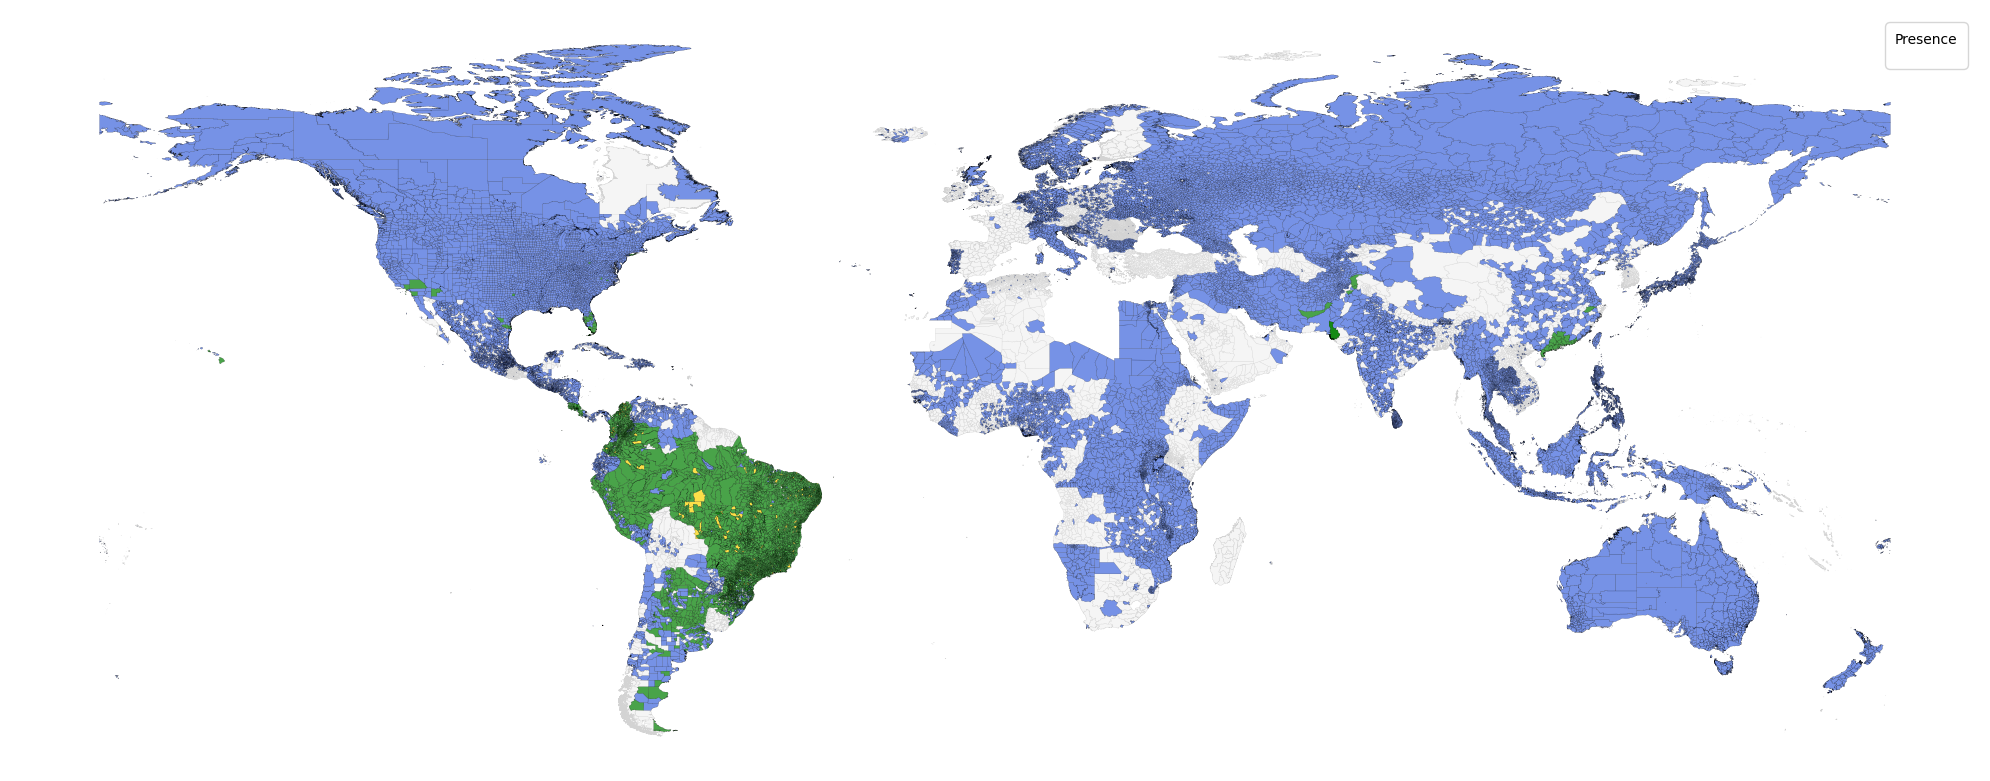

In [ ]:
 plot_dengue_plastic_overlay(dengue_merged_gdf, plastic_gdf, gadm_subset)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_dengue_plastic_overlay_select(dengue_gdf, plastic_gdf, gadm_subset,
                                dengue_col='mean_dengue_2014_2023', plastic_col='plas_litter_em'):
    """
    Plot world choropleth with:
    - Blue = Plastic only
    - Yellow = Dengue only
    - Green = Overlap of dengue and plastic
    """
    focus_countries = ['argentina', 'bolivia', 'brazil', 'chile', 'colombia',
                       'ecuador', 'guyana', 'paraguay', 'peru', 'suriname', 'uruguay', 'venezuela']
    # Clean GADM base
    # base_subset = gadm_subset[gadm_subset.adm_0_name.isin(focus_countries)]
    base = gadm_subset[gadm_subset['geometry'].notnull() & gadm_subset.is_valid]

    # Clean dengue and plastic layers
    #dengue_subset = dengue_gdf[dengue_gdf.adm_0_name.isin(focus_countries)]
    #plastic_subset = plastic_gdf[plastic_gdf.adm_0_name.isin(focus_countries)]
    dengue = dengue_gdf[dengue_gdf[dengue_col] > 0].copy()
    plastic = plastic_gdf[plastic_gdf[plastic_col] > 0].copy()

    dengue = dengue[dengue['geometry'].notnull() & dengue.is_valid]
    plastic = plastic[plastic['geometry'].notnull() & plastic.is_valid]

    # Assign source tag
    dengue['source'] = 'dengue'
    plastic['source'] = 'plastic'

    # Combine and dissolve
    combined = pd.concat([dengue[['geometry', 'source']], plastic[['geometry', 'source']]], ignore_index=True)
    overlay_union = gpd.overlay(
        gpd.GeoDataFrame(dengue, geometry='geometry'),
        gpd.GeoDataFrame(plastic, geometry='geometry'),
        how='union'
    )

    # Assign categories
    def assign_category(row):
        dengue_present = not pd.isna(row[dengue_col]) and row[dengue_col] > 0
        plastic_present = not pd.isna(row[plastic_col]) and row[plastic_col] > 0
        if dengue_present and plastic_present:
            return 'both'
        elif dengue_present:
            return 'dengue_only'
        elif plastic_present:
            return 'plastic_only'
        else:
            return 'none'

    overlay_union['category'] = overlay_union.apply(assign_category, axis=1)
    plot_gdf = overlay_union[overlay_union['category'] != 'none']

    # Plot
    fig, ax = plt.subplots(figsize=(20, 12))
    base.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey', linewidth=0.2)

    # Plot by category
    color_map = {
        'plastic_only': 'royalblue',
        'dengue_only': 'gold',
        'both': 'green'
    }

    for cat, color in color_map.items():
        plot_gdf[plot_gdf['category'] == cat].plot(
            ax=ax, color=color, edgecolor='black', linewidth=0.1, label=cat.replace('_', ' ').title(), alpha=0.7
        )

    # ax.set_title("Dengue and Plastic Overlay Map (Green = Overlap)", fontsize=16)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.legend(title="Presence")
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"dengue_plastic_overlay_map_SAmerica.pdf"), format='pdf', dpi=3000)
    plt.savefig(os.path.join(image_folder, f"dengue_plastic_overlay_map_SAmerica.jpeg"), format='jpeg', dpi=3000)
    plt.show()

<ipython-input-126-58d836b16bdf>:33: UserWarning: `keep_geom_type=True` in overlay resulted in 38105 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  overlay_union = gpd.overlay(
<ipython-input-126-58d836b16bdf>:74: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title="Presence")
<ipython-input-126-58d836b16bdf>:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Presence")


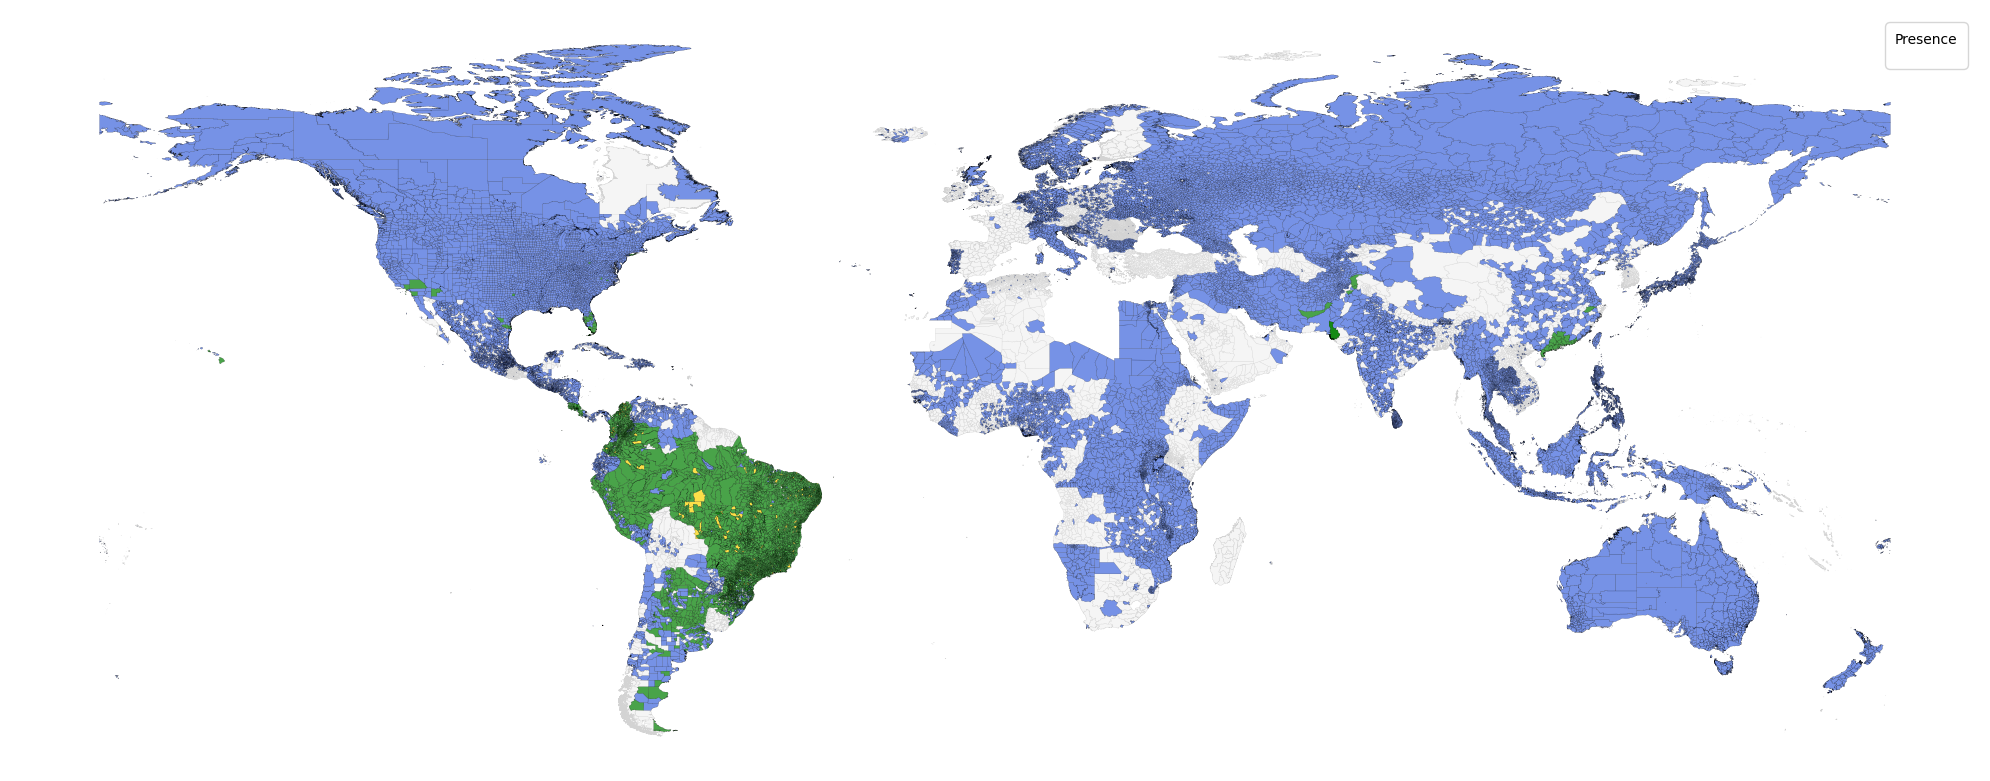

In [ ]:
plot_dengue_plastic_overlay_select(dengue_merged_gdf, plastic_gdf, gadm_subset)

In [ ]:
focus_countries = ['argentina', 'bolivia', 'brazil', 'chile', 'colombia',
                       'ecuador', 'guyana', 'paraguay', 'peru', 'suriname', 'uruguay', 'venezuela']
# Clean GADM base
base_subset = gadm_subset[gadm_subset.adm_0_name.isin(focus_countries)]
base = base_subset[base_subset['geometry'].notnull() & base_subset.is_valid]

In [ ]:
base_subset.adm_1_name.a

adm_0_name    adm_1_name              adm_2_name        GID_2  \
736    argentina  buenos aires           adolfo alsina    ARG.1.1_1   
737    argentina  buenos aires  adolfo gonzales chaves    ARG.1.2_1   
738    argentina  buenos aires                 alberti    ARG.1.3_1   
739    argentina  buenos aires         almirante brown    ARG.1.4_1   
740    argentina  buenos aires                ameghino    ARG.1.5_1   
...          ...           ...                     ...          ...   
45751  venezuela         zulia           san francisco  VEN.25.17_1   
45752  venezuela         zulia              santa rita  VEN.25.18_1   
45753  venezuela         zulia           simon bolivar  VEN.25.19_1   
45754  venezuela         zulia                   sucre  VEN.25.20_1   
45755  venezuela         zulia       valmore rodriguez  VEN.25.21_1   

                                                geometry  \
736    MULTIPOLYGON (((-63.38995 -36.51341, -63.3392 ...   
737    MULTIPOLYGON (((-60.68344 -38.09533, -60.76242...   
738    MULTIPOLYGON (((-60.32552 -35.23001, -60.32092...   
739    MULTIPOLYGON (((-58.39741 -34.91209, -58.40034...   
740    MULTIPOLYGON (((-62.27458 -35.15034, -62.2881 ...   
...                                                  ...   
45751  MULTIPOLYGON (((-71.75827 10.5302, -71.75822 1...   
45752  MULTIPOLYGON (((-71.16492 10.481, -71.1667 10....   
45753  MULTIPOLYGON (((-71.42181 10.33435, -71.39464 ...   
45754  MULTIPOLYGON (((-71.19434 8.99383, -71.19523 8...   
45755  MULTIPOLYGON (((-70.81439 10.45317, -70.81215 ...   

                          centroid  
736    POINT (-63.06024 -37.20042)  
737    POINT (-60.25158 -37.96437)  
738    POINT (-60.28662 -35.03766)  
739    POINT (-58.36831 -34.83864)  
740    POINT (-62.39806 -34.87685)  
...                            ...  
45751   POINT (-71.68563 10.57188)  
45752   POINT (-71.36948 10.54369)  
45753   POINT (-71.28439 10.31295)  
45754    POINT (-71.19825 9.13521)  
45755   POINT (-70.96409 10.16307)  

[8653 rows x 6 columns]

In [ ]:
def plot_global_plastic_choropleth(plastic_df, gadm_df, value_col='plas_litter_em'):
    # Ensure string types
    plastic_df = plastic_df.copy()
    plastic_df['adm_0_name'] = plastic_df['adm_0_name'].astype(str)
    plastic_df['adm_2_name'] = plastic_df['adm_2_name'].astype(str)
    gadm_df['adm_0_name'] = gadm_df['adm_0_name'].astype(str)
    gadm_df['adm_2_name'] = gadm_df['adm_2_name'].astype(str)

    focus_countries = ['argentina', 'bolivia', 'brazil', 'chile', 'colombia',
                       'ecuador', 'guyana', 'paraguay', 'peru', 'suriname', 'uruguay', 'venezuela']
    # Clean GADM base
    plastic_df = plastic_df[plastic_df.adm_0_name.isin(focus_countries)]
    gadm_df = gadm_df[gadm_df.adm_0_name.isin(focus_countries)]


    geometries = []
    for idx, row in plastic_df.iterrows():
        country = row['adm_0_name']
        muni = row['adm_2_name']

        # Get gadm candidates for the same country
        gadm_country = gadm_df[gadm_df['adm_0_name'].str.lower() == country.lower()]
        matches = get_close_matches(muni, gadm_country['adm_2_name'], n=1)

        if matches:
            geom = gadm_country[gadm_country['adm_2_name'] == matches[0]].geometry.values[0]
        else:
            geom = None

        geometries.append(geom)

    # Attach geometries to plastic data
    plastic_df['geometry'] = geometries
    gdf = gpd.GeoDataFrame(plastic_df, geometry='geometry')
    gdf = gdf[gdf.geometry.notna() & gdf.is_valid]

    # Plot
    fig, ax = plt.subplots(figsize=(22, 14))
    gadm_df[gadm_df.geometry.notna() & gadm_df.is_valid].plot(
        ax=ax, color='whitesmoke', edgecolor='lightgrey', linewidth=0.2
    )

    gdf.plot(
        column=value_col,
        cmap='Blues',
        edgecolor='black',
        ax=ax,
        legend=True,
        linewidth=0.1,
        legend_kwds={"shrink": 0.6},
        vmin=0,
        vmax=plastic_df[value_col].max()
    )

    #ax.set_title("Global Plastic Litter Emission by Municipality", fontsize=18)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(image_folder, f"global_{value_col}_map_SA.pdf"), format='pdf', dpi=3000)
    plt.savefig(os.path.join(image_folder, f"global_{value_col}_map_SA.png"), format='png', dpi=3000)
    plt.show()

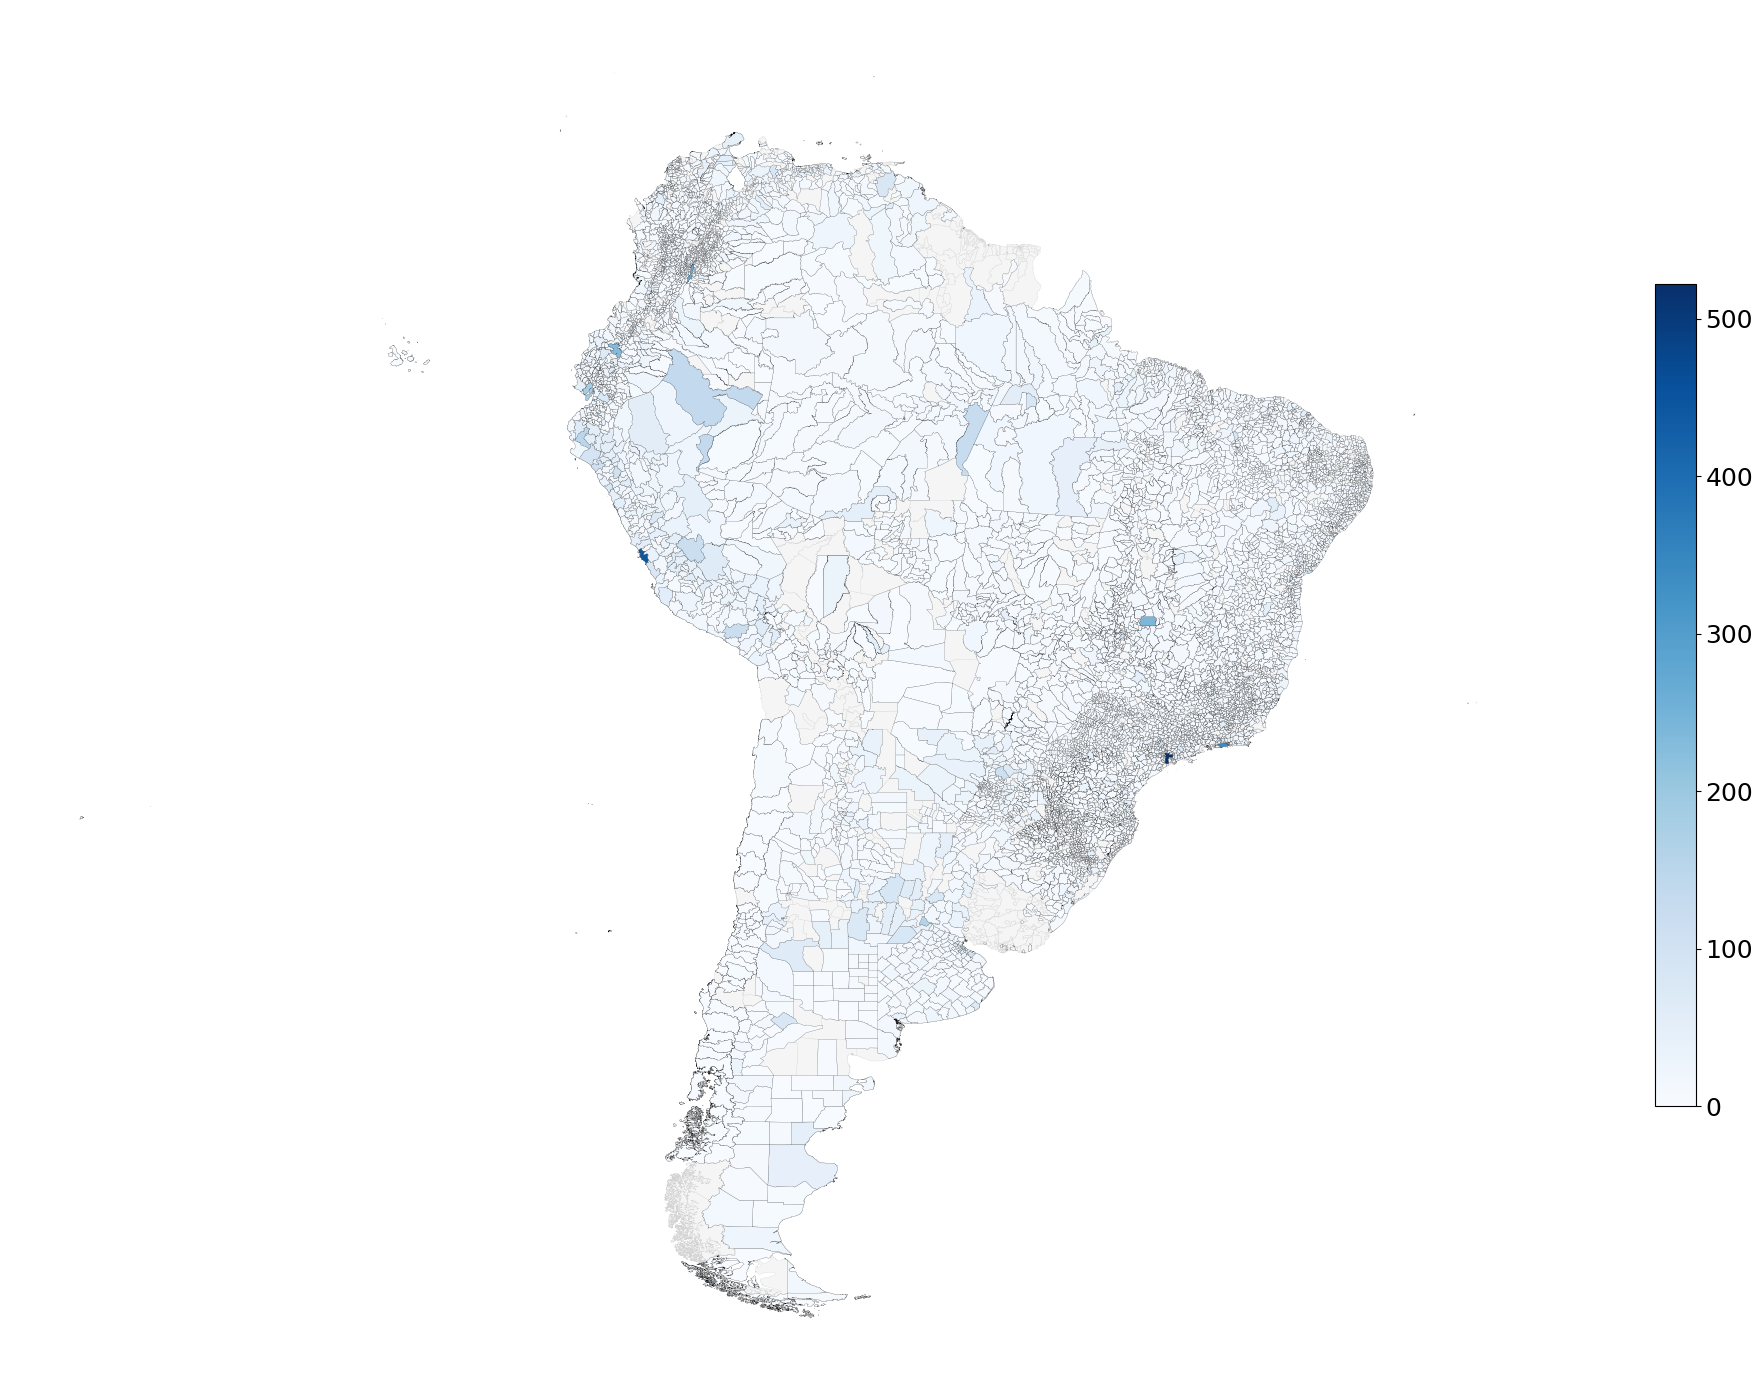

In [ ]:
plot_global_plastic_choropleth(plastic_median_subset, gadm_subset)

In [ ]:
def plot_dengue_prevalence_score_map(plastic_dengue_merged, gadm_subset, pop_col='Population_2020', dengue_col='mean_dengue_2014_2023'):
    """
    Plot dengue prevalence scores across municipalities using WHO-style risk thresholds.

    Parameters:
    - plastic_dengue_merged (GeoDataFrame): GeoDataFrame with dengue cases, population, and geometries
    - gadm_subset (GeoDataFrame): GADM admin boundaries with geometries
    - pop_col (str): Name of the population column
    - dengue_col (str): Name of the dengue column
    """

    # 1. Compute incidence rate per 100,000
    df = plastic_dengue_merged.copy()
    df['incidence_rate'] = (df[dengue_col] / df[pop_col]) * 100_000

    # 2. Assign prevalence score
    def compute_prevalence_score(inc):
        if inc == 0:
            return 0  # No transmission
        elif inc < 50:
            return 1  # Sporadic
        elif inc < 100:
            return 2  # Low risk
        elif inc < 300:
            return 3  # Medium risk
        else:
            return 4  # High risk

    df['prevalence_score'] = df['incidence_rate'].apply(compute_prevalence_score)

    # 3. Filter for valid geometries and countries
    focus_countries = ['argentina', 'bolivia', 'brazil', 'chile', 'colombia',
                       'ecuador', 'guyana', 'paraguay', 'peru', 'suriname', 'uruguay', 'venezuela']
    #df = df[df['adm_0_name'].isin(focus_countries)]
    df = df[df.geometry.notna() & df.is_valid]

    #gadm_subset = gadm_subset[gadm_subset['adm_0_name'].isin(focus_countries)]
    base = gadm_subset[gadm_subset.geometry.notna() & gadm_subset.is_valid]

    # 4. Plot choropleth
    fig, ax = plt.subplots(figsize=(20, 14))
    base.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey', linewidth=0.3)

    df.plot(
        column='prevalence_score',
        cmap='OrRd',
        edgecolor='black',
        linewidth=0.1,
        legend=True,
        ax=ax,
        legend_kwds={'title': 'Dengue Prevalence Score'},
        categorical=True
    )

    # Labels and styling
    #ax.set_title("Dengue Prevalence Score by Municipality (WHO thresholds)", fontsize=18)
    ax.axis("off")
    plt.tight_layout()

    # Save
    plt.savefig(os.path.join(image_folder, f"dengue_prevalence_map.pdf"), format='pdf', dpi=3000)
    plt.savefig(os.path.join(image_folder, f"dengue_prevalence_map.png"), format='png', dpi=3000)
    plt.show()


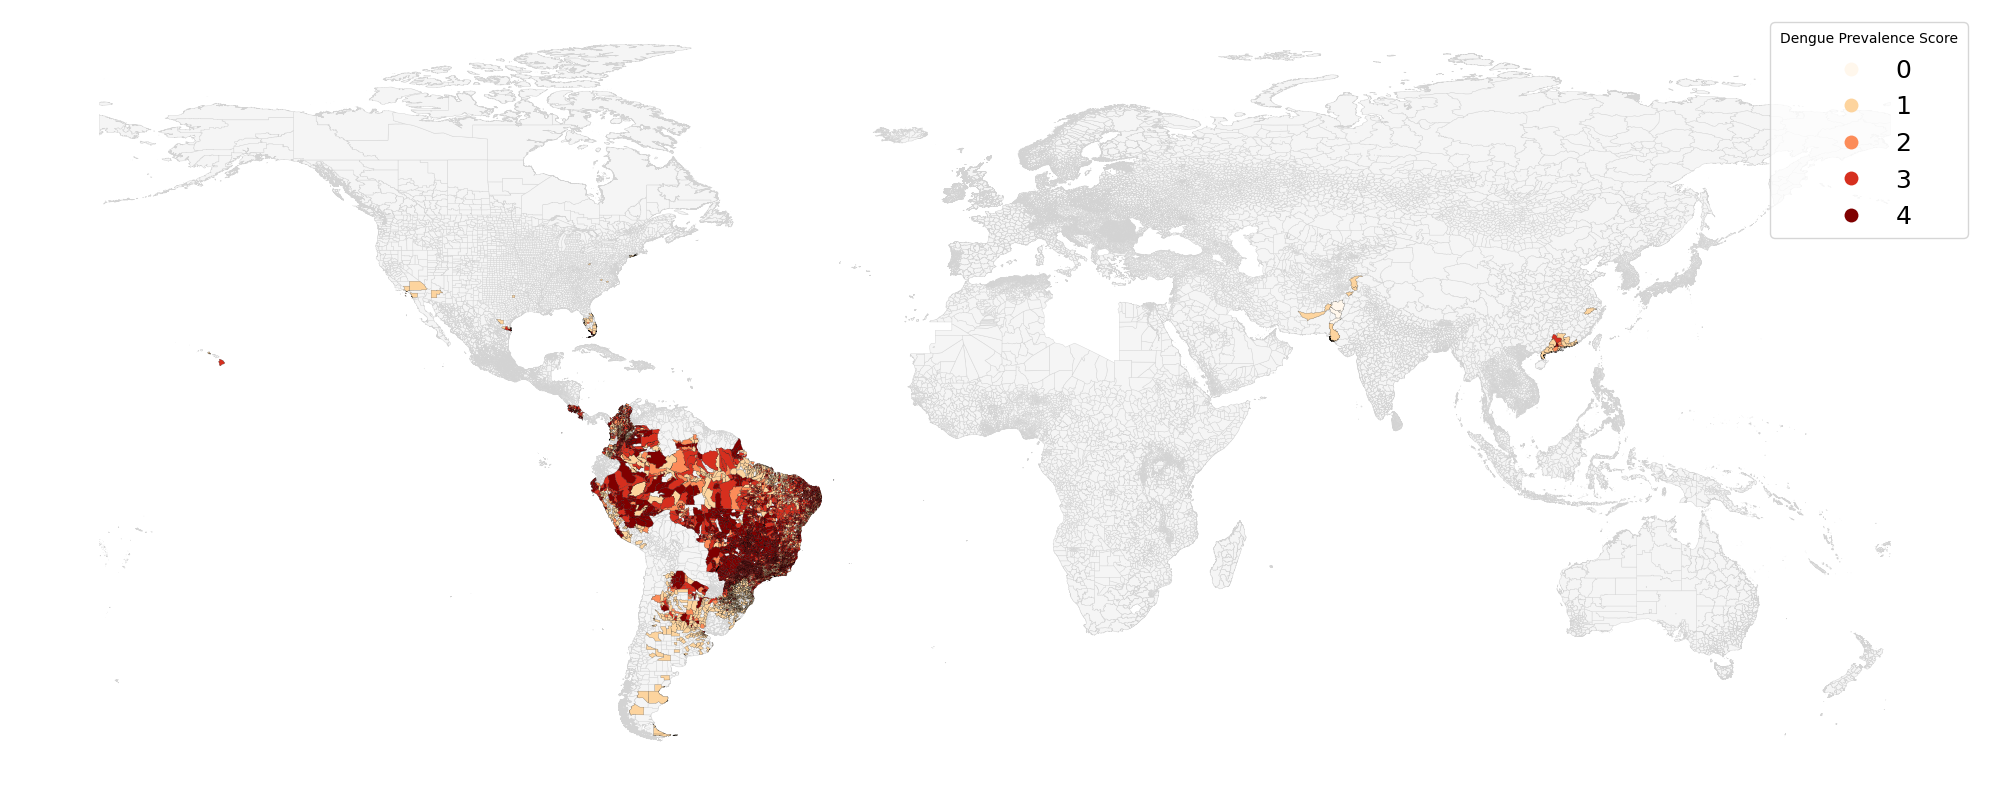

In [ ]:
plot_dengue_prevalence_score_map(
    plastic_dengue_merged, gadm_subset,
    pop_col='Population_2020',
    dengue_col='mean_dengue_2014_2023')


In [ ]:
def plot_plastic_hotspot_map(plastic_dengue_merged, gadm_subset, plastic_col='plastic_median'):
    """
    Plot plastic waste generation hotspots using the 90th percentile threshold method.

    Parameters:
    - plastic_dengue_merged (GeoDataFrame): Contains plastic pollution estimates and geometries.
    - gadm_subset (GeoDataFrame): Full GADM admin boundaries with geometries.
    - plastic_col (str): Column name with plastic waste values (default: 'plastic_median').
    """

    df = plastic_dengue_merged.copy()

    # 1. Compute 90th percentile threshold
    threshold = df[plastic_col].quantile(0.90)

    # 2. Label hotspots
    df['plastic_hotspot'] = df[plastic_col] > threshold

    # 3. Filter for valid geometries and countries
    focus_countries = ['argentina', 'bolivia', 'brazil', 'chile', 'colombia',
                       'ecuador', 'guyana', 'paraguay', 'peru', 'suriname', 'uruguay', 'venezuela']
    #df = df[df['adm_0_name'].isin(focus_countries)]
    df = df[df.geometry.notna() & df.is_valid]

    #gadm_subset = gadm_subset[gadm_subset['adm_0_name'].isin(focus_countries)]
    base = gadm_subset[gadm_subset.geometry.notna() & gadm_subset.is_valid]

    # 4. Plot choropleth
    fig, ax = plt.subplots(figsize=(20, 14))
    base.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey', linewidth=0.3)

    df.plot(
        column='plastic_hotspot',
        cmap='coolwarm',
        edgecolor='black',
        linewidth=0.1,
        legend=True,
        ax=ax,
        legend_kwds={'title': 'Plastic Hotspot'},
        categorical=True
    )

    ax.axis("off")
    plt.tight_layout()

    # Save
    plt.savefig(os.path.join(image_folder, f"plastic_hotspot_map.pdf"), format='pdf', dpi=3000)
    plt.savefig(os.path.join(image_folder, f"plastic_hotspot_map.png"), format='png', dpi=3000)
    plt.show()


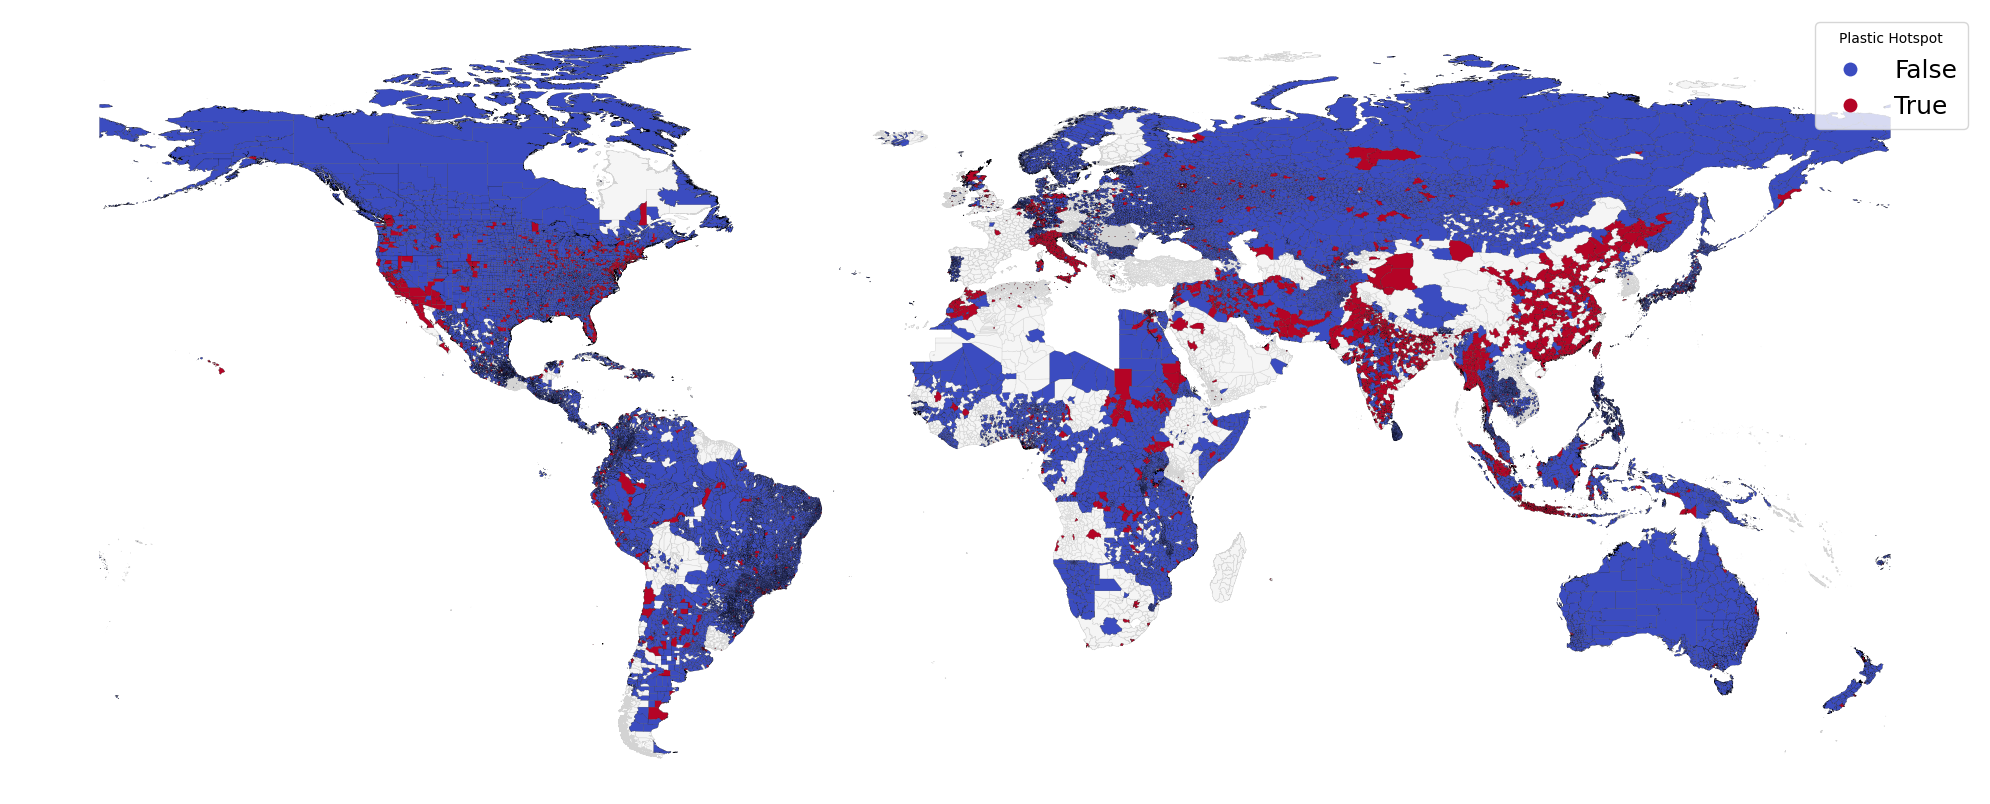

In [ ]:
plot_plastic_hotspot_map(plastic_gdf, gadm_subset, plastic_col='pwg')

In [ ]:
plastic_dengue_merged.shape

(6480, 67)